# Chapter 4 Homework Answers

In [1]:
from scipy import stats
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from watermark import watermark
from patsy import dmatrix

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

In [3]:
%load_ext watermark
%watermark

Last updated: 2024-06-25T20:22:01.506014-04:00

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.17.2

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 141 Stepping 1, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [4]:
%watermark --iversions

pandas    : 2.1.3
numpy     : 1.25.2
matplotlib: 3.8.2
scipy     : 1.11.3
arviz     : 0.16.1
pymc      : 5.9.2
seaborn   : 0.13.2



# Answers to Easy Questions

4E1: 1st line is likehood

4E2: two parameters, mu and sigma

4E3: (Normal(mu,sigma) * Normal(0,10) * Exponential(1)) / Integral ((Normal(mu,sigma) * Normal(0,10) * Exponential(1))

4E4: ui = a+bxi is the linear model

4E5: 3 patmaters, a, b, and sigma

# 4M1

In [5]:
mu = np.random.normal(0,10)
sigma = np.random.exponential(1)
y = np.random.normal(mu,sigma, 1000)

(array([  3.,  21.,  46., 118., 214., 260., 184., 105.,  39.,  10.]),
 array([-5.71566474, -5.44666873, -5.17767272, -4.90867671, -4.6396807 ,
        -4.37068469, -4.10168869, -3.83269268, -3.56369667, -3.29470066,
        -3.02570465]),
 <BarContainer object of 10 artists>)

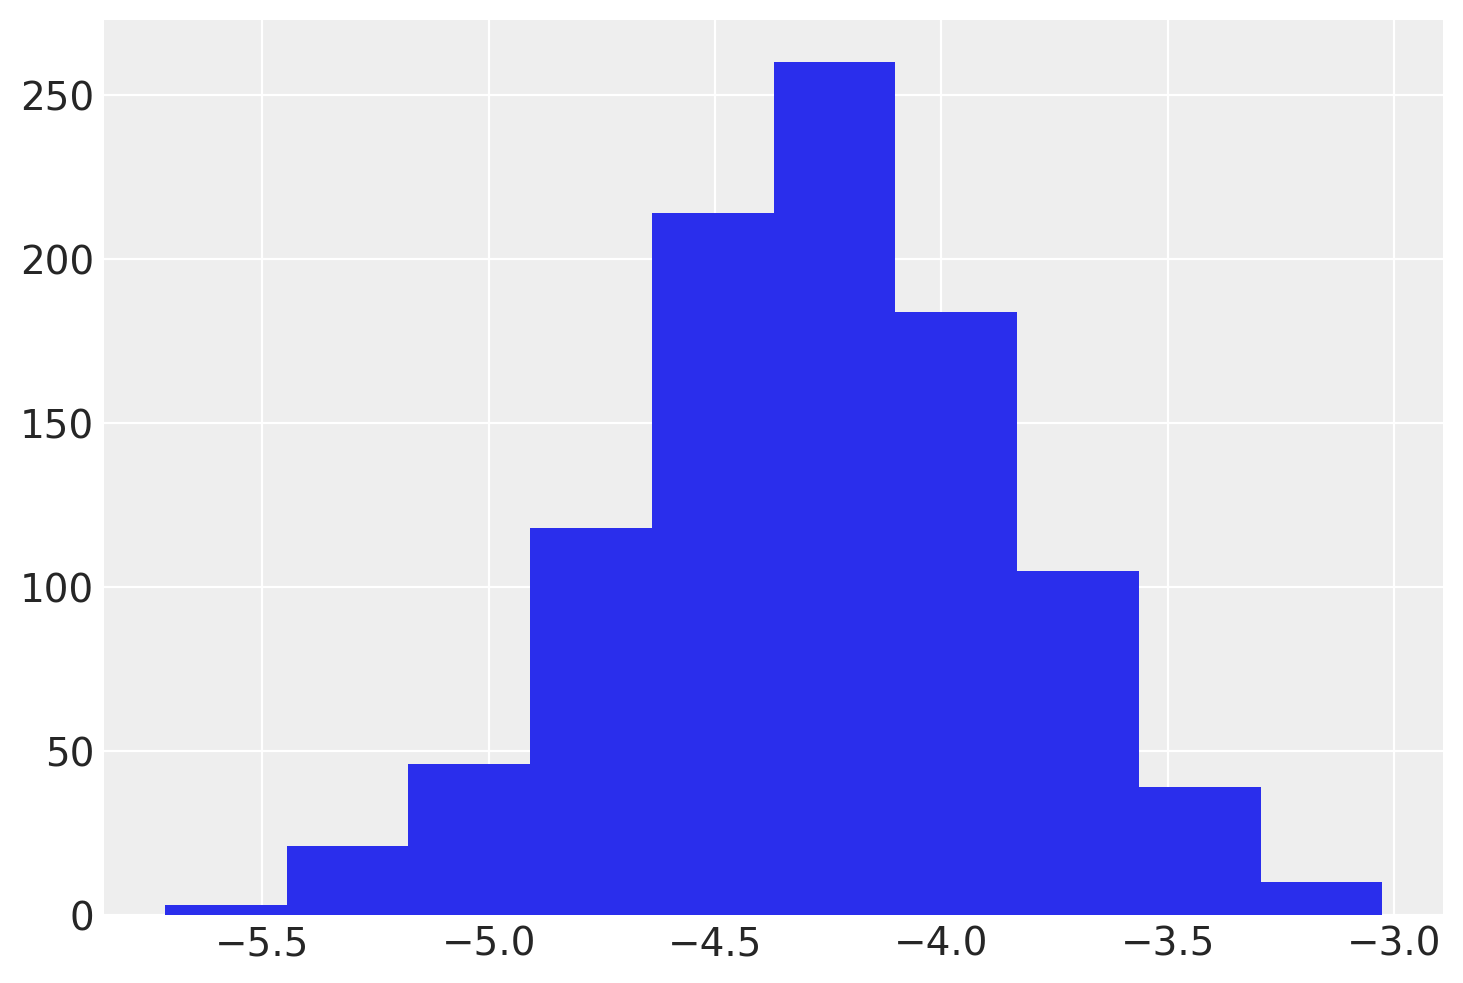

In [6]:
plt.hist(y)

4M2: quap form isn't relevant to pymc

4M3: quap form isn't relevant to pymc

4M4:

y = Normal(mu, sigma)

ui = a + Bxi

a = Normal(0, 100) 

b = Normal(0,1)

sigma = Uniform (0,50)

4M5 
b = LogNormal(0,1) = Encodes that height only increases

4M6
sigma = Uniform (0,64) 

# 4M7

In [7]:
data_raw = pd.read_csv("./data/Howell1.csv", sep=';')
data_raw.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0

In [8]:
data = data_raw[data_raw['age'] >= 18]

In [9]:
data_raw.shape, data.shape

((544, 4), (352, 4))

In [10]:
x_bar = data['weight'].mean() 
with pm.Model() as m4m7_a:
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.Normal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0,50)
    mu = a + b*(data['weight'].values - x_bar)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=data['height'].values)  
    m4m7_a_trace= pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [11]:
az.summary( m4m7_a_trace, kind="stats")

mean     sd  hdi_5.5%  hdi_94.5%
a      154.605  0.269   154.186    155.049
b        0.903  0.042     0.836      0.968
sigma    5.105  0.193     4.794      5.407

In [12]:
m4m7_a_trace_df =  m4m7_a_trace.posterior.to_dataframe()
m4m7_a_trace_df.corr().round(3)

a      b  sigma
a      1.000 -0.011 -0.011
b     -0.011  1.000 -0.007
sigma -0.011 -0.007  1.000

In [13]:
#4M7
x_bar = data['weight'].mean() 
with pm.Model() as m4m7_b:
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.Normal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0,50)
    mu = a + b*(data['weight'].values)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=data['height'].values)  
    m4m7_b_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


In [14]:
az.summary(m4m7_b_trace, kind="stats")

mean     sd  hdi_5.5%  hdi_94.5%
a      114.590  1.969   111.429    117.744
b        0.890  0.043     0.822      0.962
sigma    5.107  0.193     4.792      5.407

In [15]:
m4m7_b_trace_df =  m4m7_b_trace.posterior.to_dataframe()
m4m7_b_trace_df.corr().round(3)

a      b  sigma
a      1.000 -0.991  0.019
b     -0.991  1.000 -0.019
sigma  0.019 -0.019  1.000

Text(0, 0.5, 'Height')

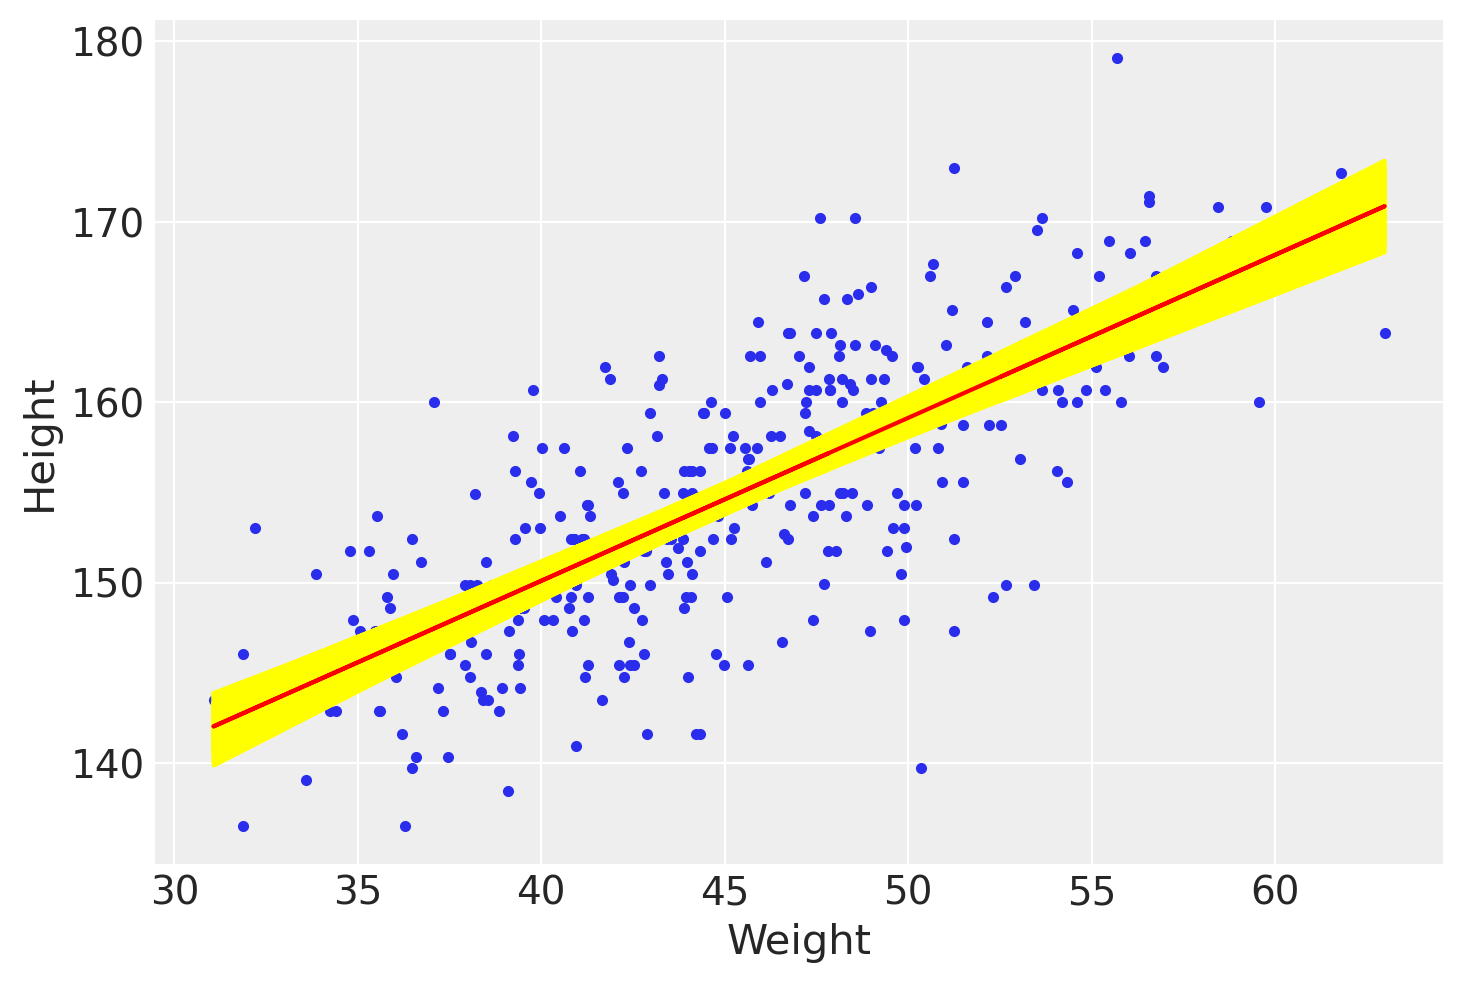

In [16]:
plt.plot(data['weight'], data['height'], '.')
for i in range(1000):
    plt.plot(data['weight'],
         m4m7_a_trace.posterior['a'].item(i) 
         + m4m7_a_trace.posterior['b'].item(i) * (data['weight'] - x_bar), color='yellow')
    
plt.plot(data['weight'],
         m4m7_a_trace.posterior['a'].mean().item(0) 
         + m4m7_a_trace.posterior['b'].mean().item(0) * (data['weight'] - x_bar), color='red')

plt.xlabel('Weight')
plt.ylabel('Height')

Text(0, 0.5, 'Height')

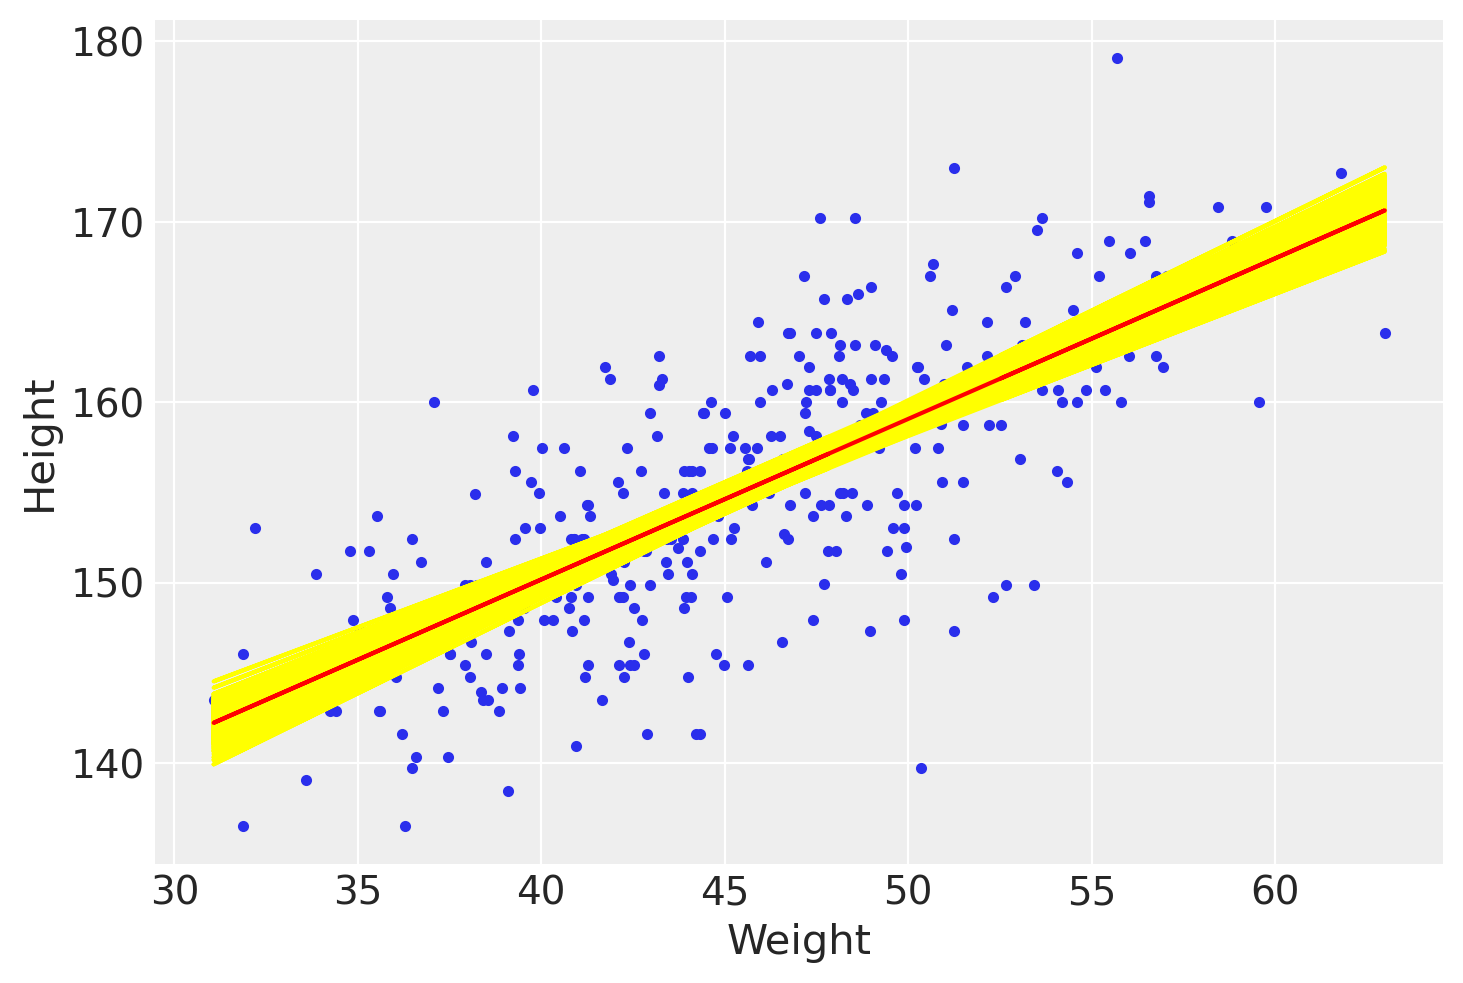

In [17]:
plt.plot(data['weight'], data['height'], '.')
for i in range(1000):
    plt.plot(data['weight'],
         m4m7_b_trace.posterior['a'].item(i) 
         + m4m7_b_trace.posterior['b'].item(i) * (data['weight']), color='yellow')
    
plt.plot(data['weight'],
         m4m7_b_trace.posterior['a'].mean().item(0) 
         + m4m7_b_trace.posterior['b'].mean().item(0) * (data['weight']), color='red')

plt.xlabel('Weight')
plt.ylabel('Height')

D:\Python\venv\pymc_env\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


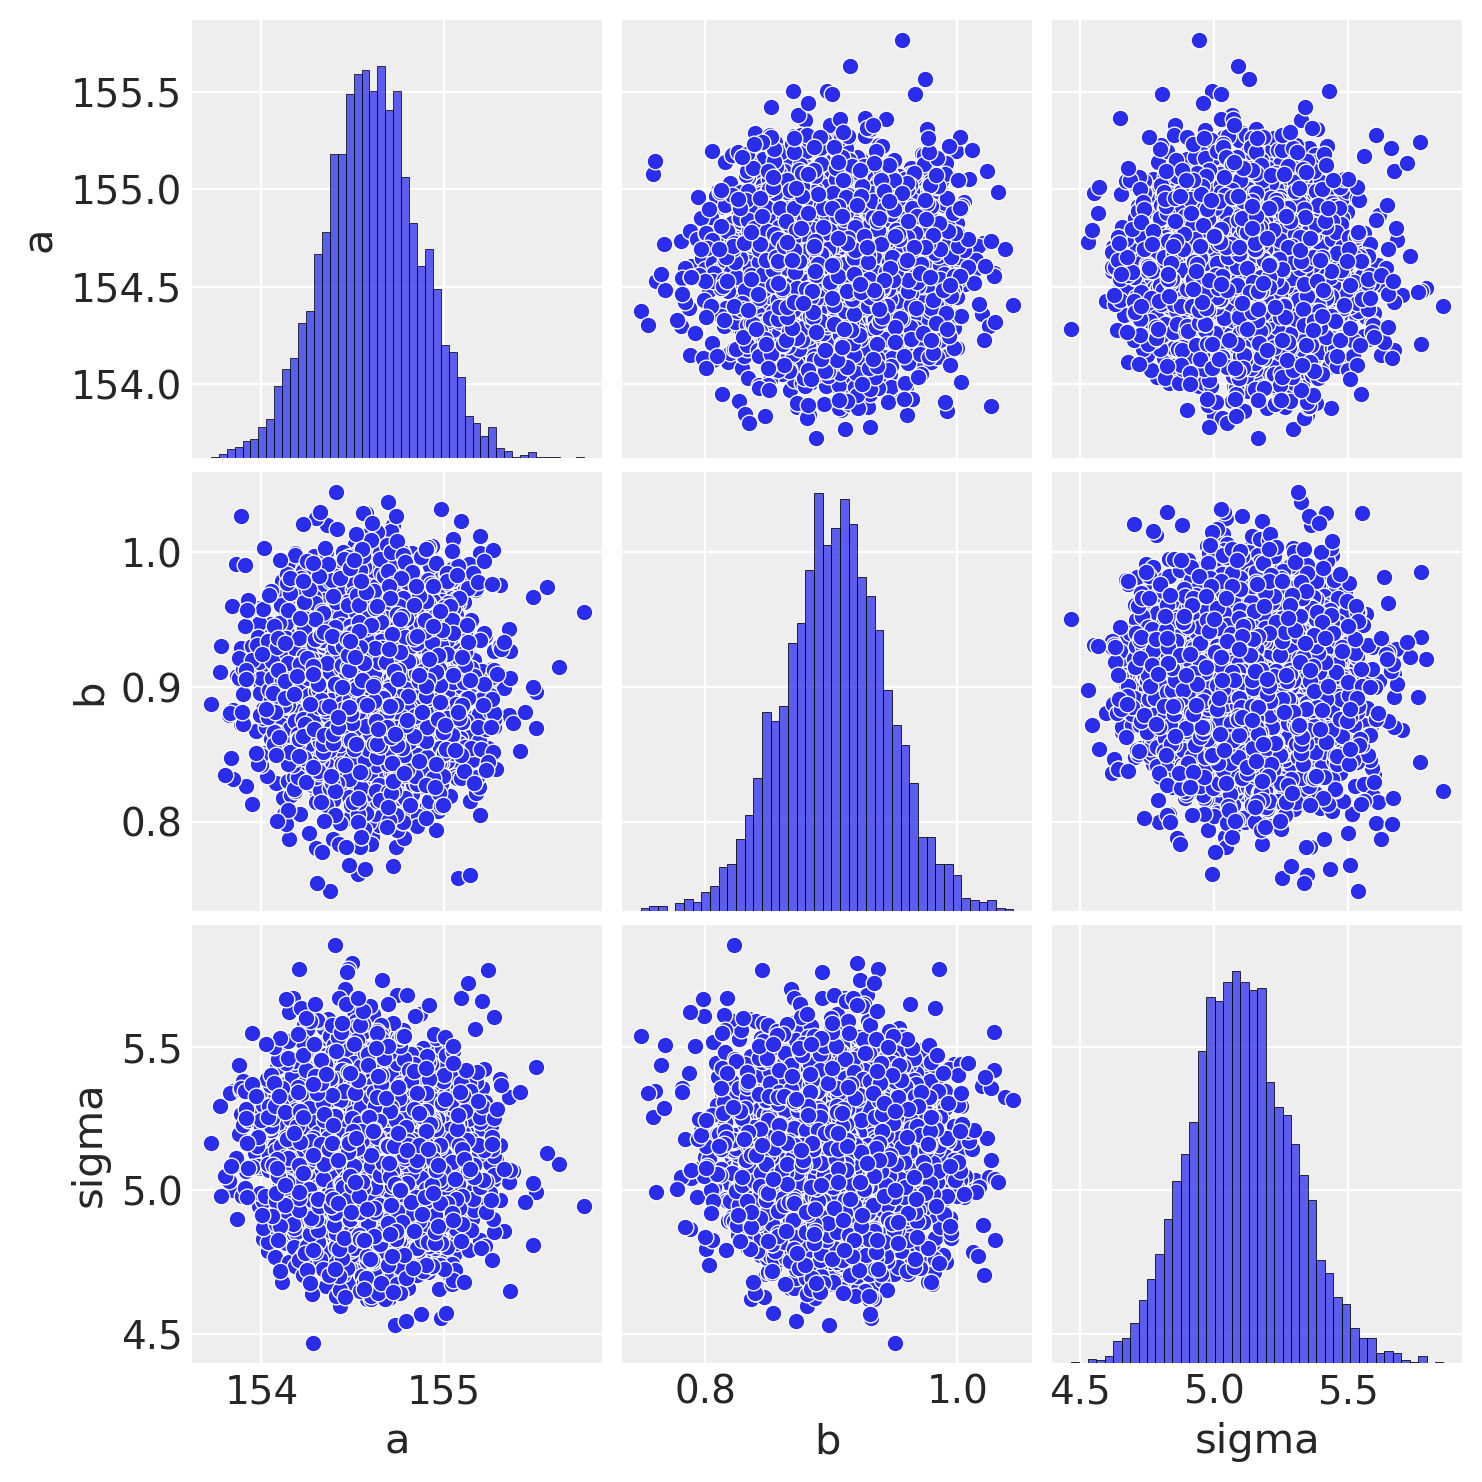

In [18]:
sns.pairplot(m4m7_a_trace_df)

D:\Python\venv\pymc_env\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


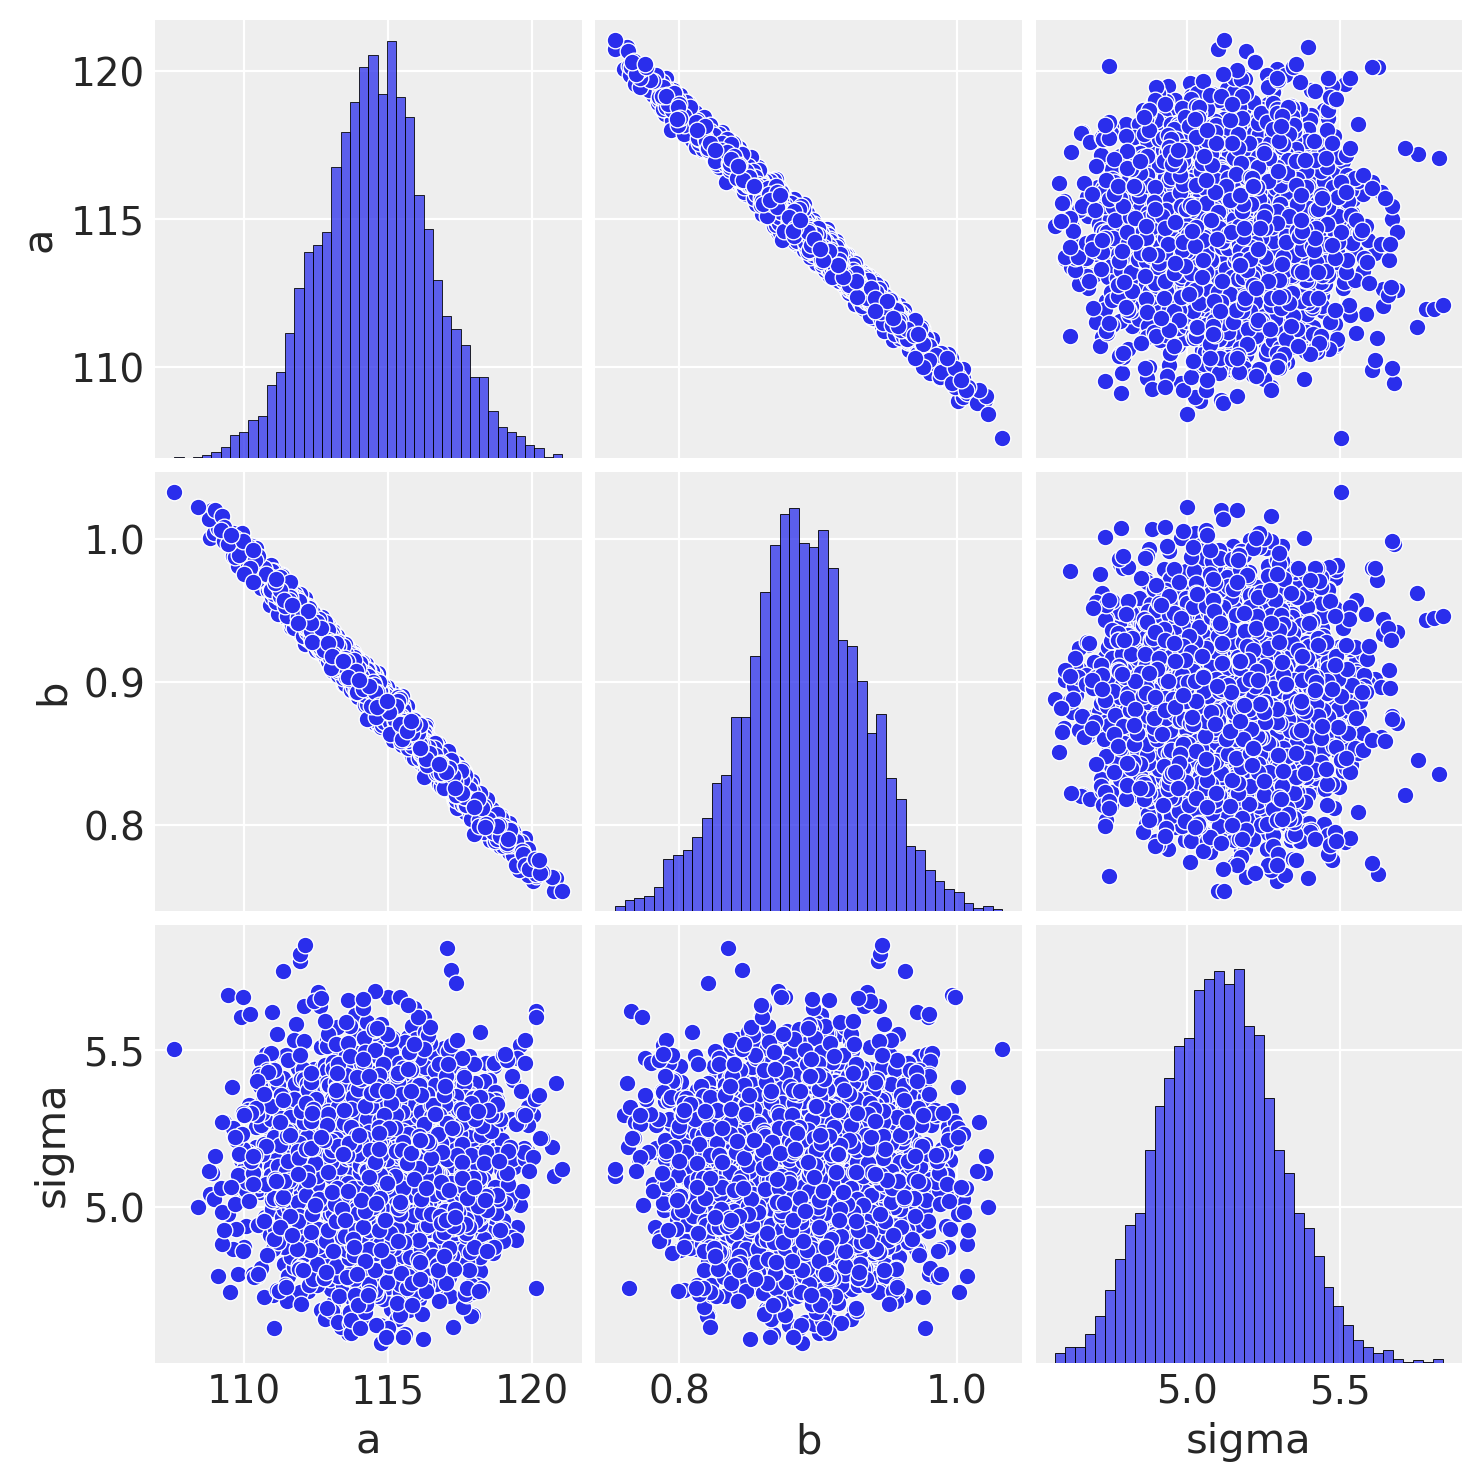

In [19]:
sns.pairplot(m4m7_b_trace_df)

In [20]:
m4m7_b_trace_df.corr()

a         b     sigma
a      1.000000 -0.990604  0.018756
b     -0.990604  1.000000 -0.018967
sigma  0.018756 -0.018967  1.000000

In [21]:
weight_seq = np.arange(31, 64)

In [22]:
a_values =  m4m7_a_trace['posterior']['a'][0]
b_values =  m4m7_a_trace['posterior']['b'][0]
predictions = np.zeros((len(weight_seq), len(a_values)))

In [23]:
for i, value in enumerate(weight_seq):
    predictions[i] = a_values + (b_values * (value - x_bar))

In [24]:
predictions_mean = predictions.mean(1)
predictions_hdi = az.hdi(predictions_mean.T)

In [25]:
with  m4m7_a:
    height_pred = pm.sample_posterior_predictive(m4m7_a_trace)

Sampling: [height]


D:\Python\venv\pymc_env\lib\site-packages\arviz\plots\hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


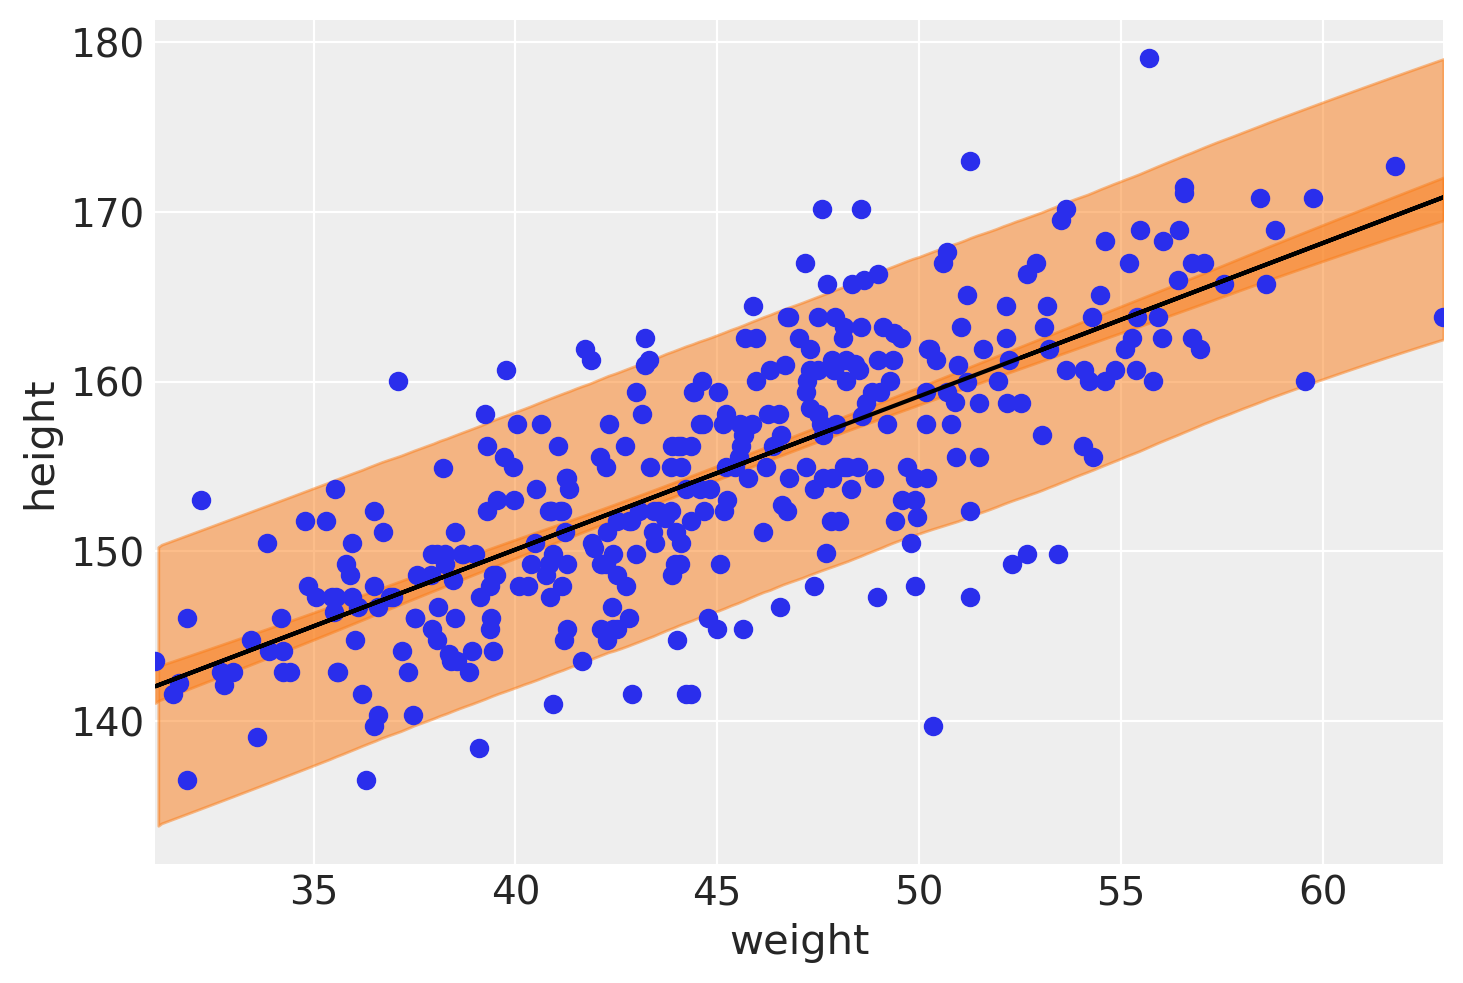

In [26]:
ax = az.plot_hdi(weight_seq, predictions.T, hdi_prob=0.89)
az.plot_hdi(data['weight'], height_pred.posterior_predictive['height'], ax=ax, hdi_prob=0.89)
plt.scatter(data['weight'],data['height'])
plt.plot(data['weight'],
          m4m7_a_trace.posterior['a'].mean().item(0) 
         +  m4m7_a_trace.posterior['b'].mean().item(0) * (data['weight'] - x_bar), color='black')
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(data['weight'].min(), data['weight'].max());

# 4M8

In [27]:
cherry_data_raw = pd.read_csv("./data/cherry_blossoms.csv")
# nans are not treated as in the book
az.summary(cherry_data_raw.dropna().to_dict(orient="list"), kind="stats")

mean       sd  hdi_5.5%  hdi_94.5%
year        1533.395  291.123   1123.00    1978.00
doy          104.921    6.258     95.00     114.00
temp           6.100    0.683      5.00       7.13
temp_upper     6.938    0.812      5.57       7.98
temp_lower     5.264    0.762      4.12       6.40

Text(0.5, 0, 'day of first blossom')

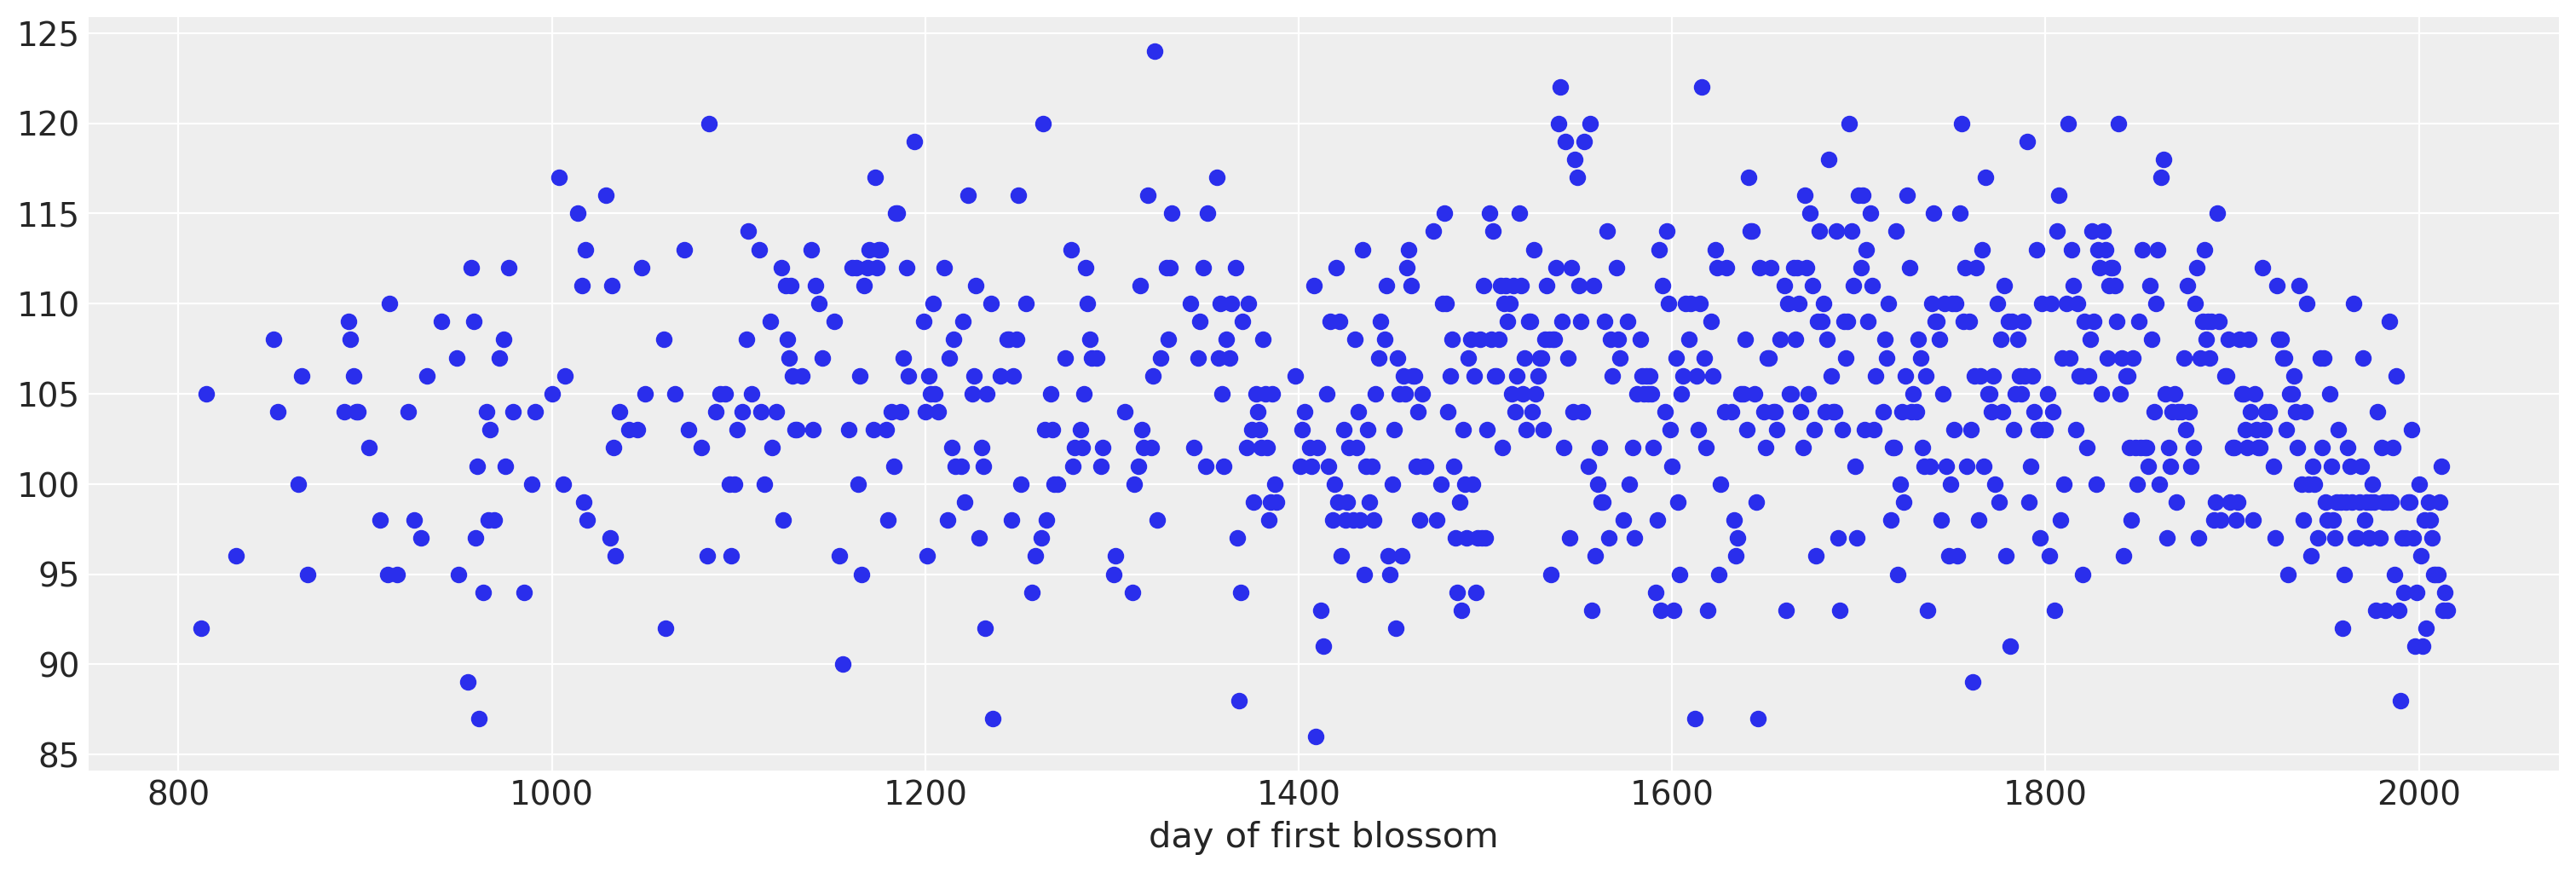

In [28]:
plt.figure(figsize=(15,5))
plt.scatter(cherry_data_raw['year'],cherry_data_raw['doy'])
plt.xlabel('year')
plt.xlabel('day of first blossom')

In [29]:
cherry_data = cherry_data_raw.dropna(subset=['doy'])

In [30]:
num_knots = 15
knot_list = np.quantile(cherry_data['year'],np.linspace(0,1,num_knots))

In [31]:
from patsy import dmatrix

B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True)-1",
    {"year": cherry_data['year'].values, "knots": knot_list[1:-1]},
)

In [32]:
import matplotlib.colors as mcolors
color_lookup = list(mcolors.XKCD_COLORS)

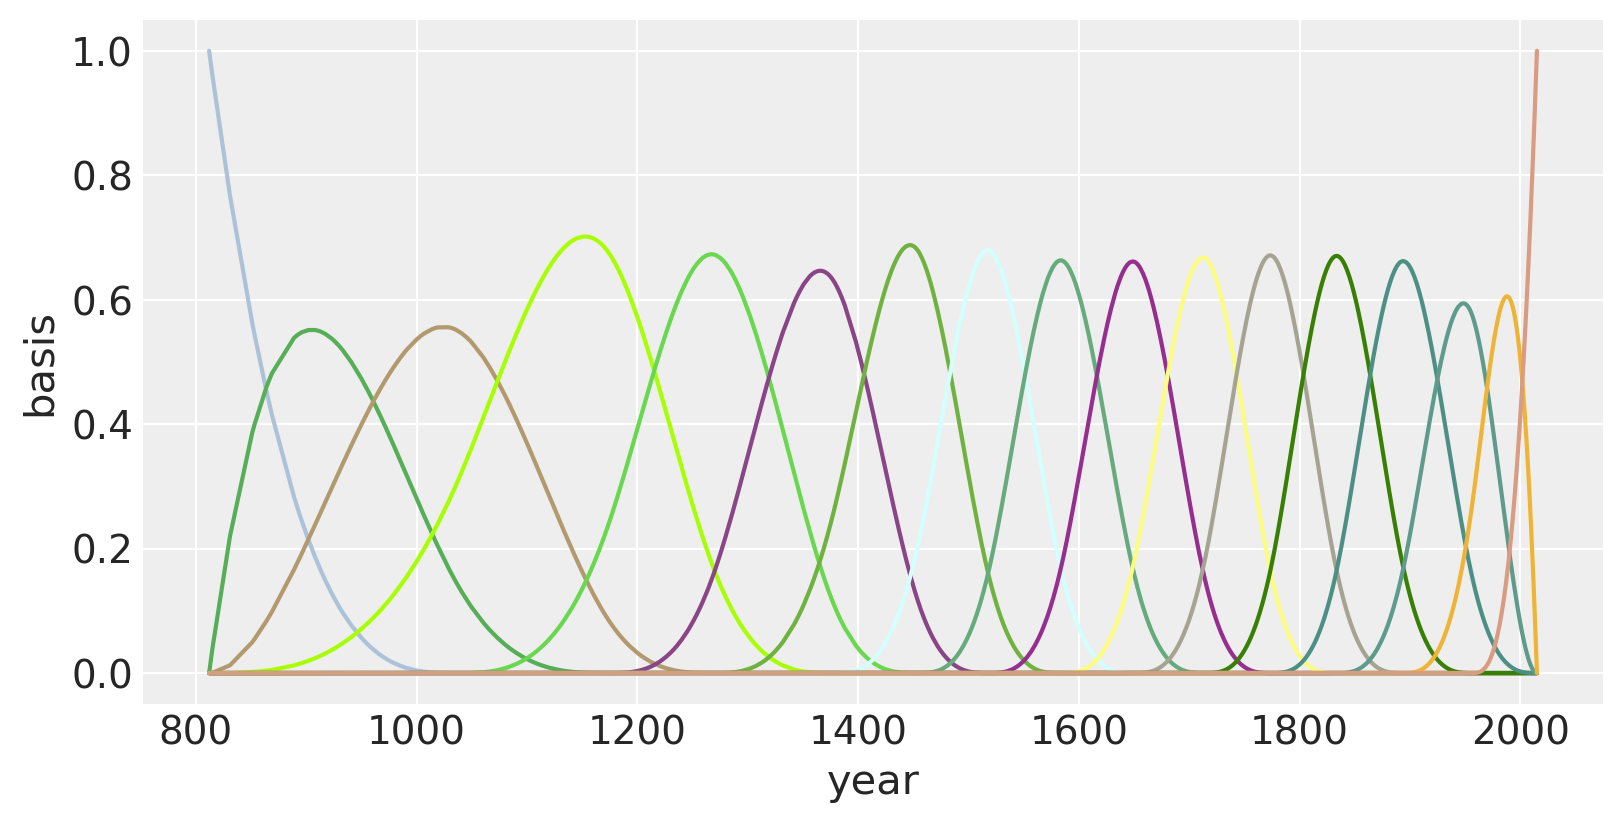

In [33]:
_, ax = plt.subplots(1, 1, figsize=(8, 4))
for i in range(B.shape[1]):
    ax.plot(cherry_data['year'], (B[:, i]), color=color_lookup[i])
ax.set_xlabel("year")
ax.set_ylabel("basis");

In [34]:
with pm.Model() as m4m8_a:
    a = pm.Normal('a', 100,10)
    w = pm.Normal('w', mu=0, sigma=10, shape=B.shape[1])
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic("mu", a + pm.math.dot(B.base, w.T))
    D = pm.Normal('D', mu, sigma, observed=cherry_data['doy'])
    m4m8_a_trace = pm.sample(1000)                       

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


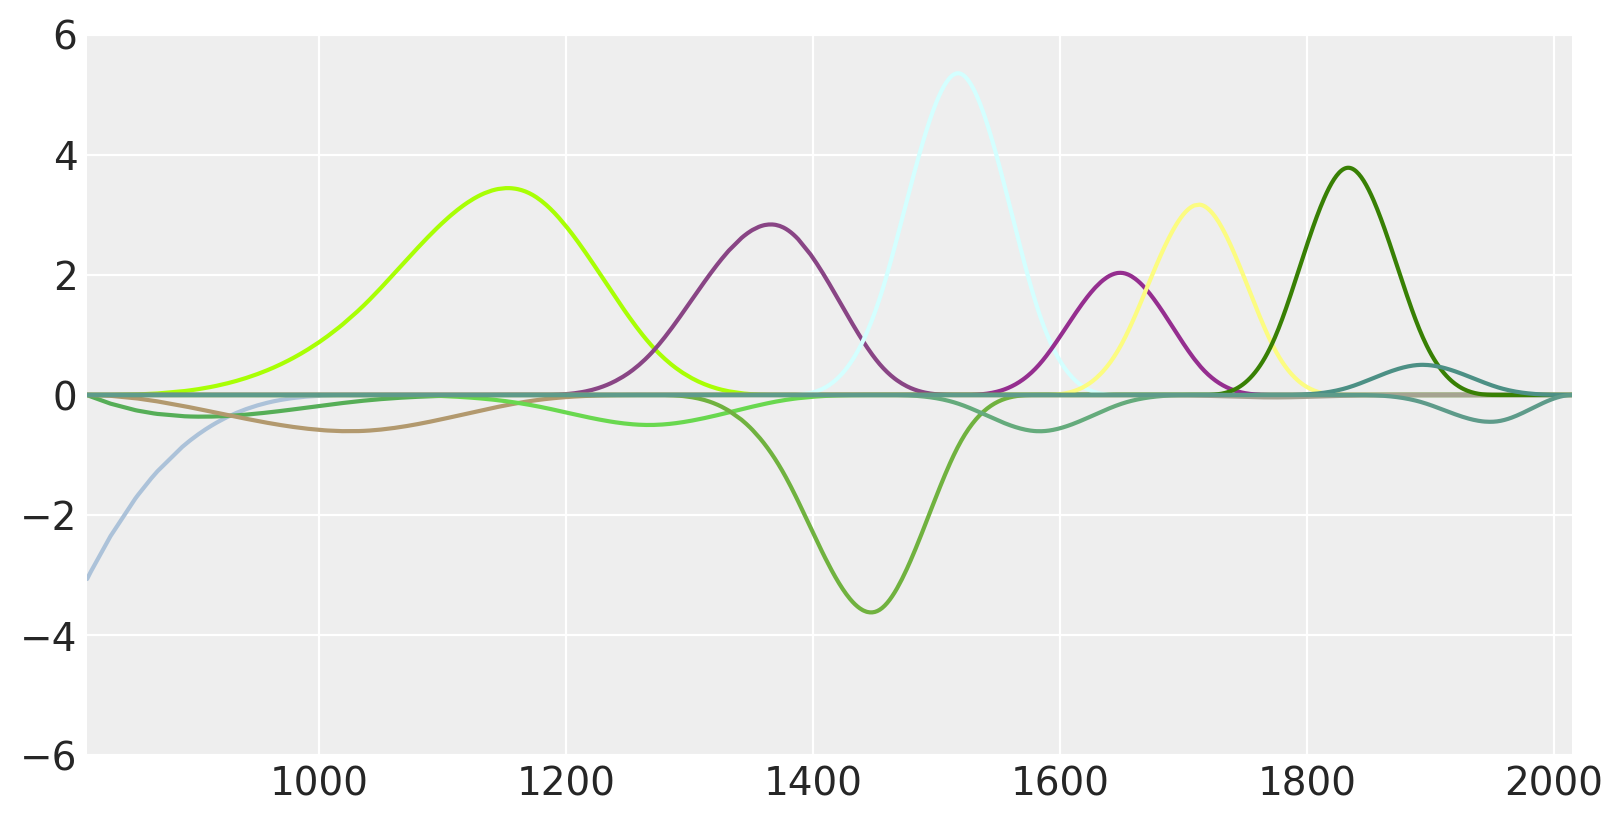

In [35]:
_, ax = plt.subplots(1, 1, figsize=(8, 4))
wp = m4m8_a_trace.posterior.w.mean(dim=["chain", "draw"])
for i in range(num_knots):
    ax.plot(cherry_data['year'], (wp[i].item(0) * B[:, i]), color=color_lookup[i])
ax.set_xlim(812, 2015)
ax.set_ylim(-6, 6);

Text(0, 0.5, 'days in year')

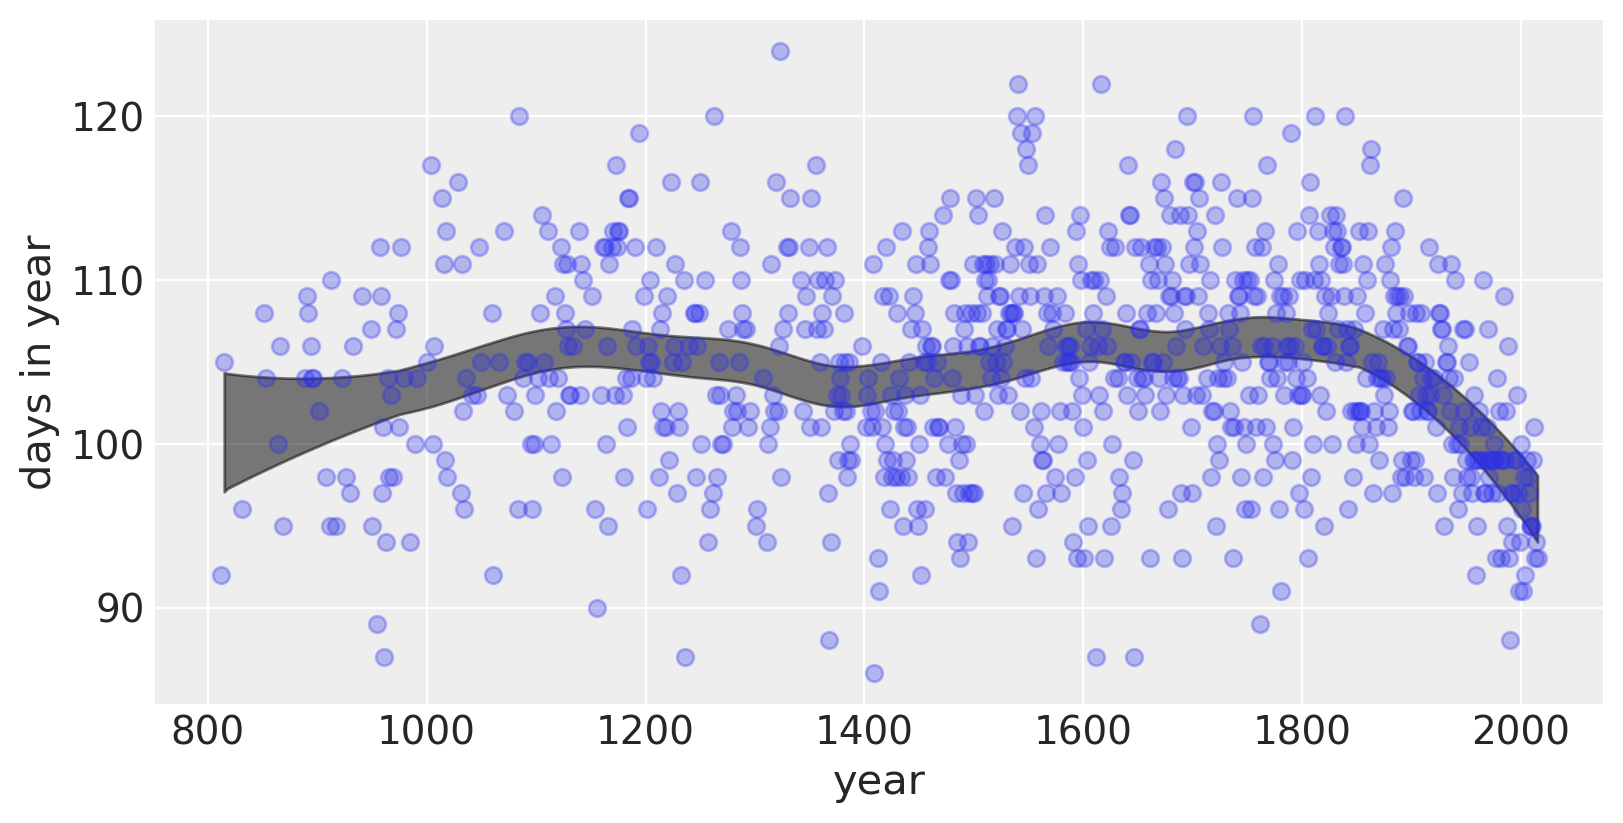

In [36]:
ax = az.plot_hdi(cherry_data.year, m4m8_a_trace.posterior["mu"], color="k")
ax.plot(cherry_data.year, cherry_data.doy, "o", alpha=0.3)
fig = plt.gcf()
fig.set_size_inches(8, 4)
ax.set_xlabel("year")
ax.set_ylabel("days in year")

In [37]:
num_knots = 25
knot_list = np.quantile(cherry_data['year'],np.linspace(0,1,num_knots))

In [38]:
from patsy import dmatrix

B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True)-1",
    {"year": cherry_data['year'].values, "knots": knot_list[1:-1]},
)

In [39]:
with pm.Model() as m4m8_b:
    a = pm.Normal('a', 100,10)
    w = pm.Normal('w', mu=0, sigma=10, shape=B.shape[1])
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic("mu", a + pm.math.dot(B.base, w.T))
    D = pm.Normal('D', mu, sigma, observed=cherry_data['doy'])
    m4m8_b_trace = pm.sample(1000)                       

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [40]:
az.summary(m4m8_a_trace)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a        103.276  2.386    99.763    107.247      0.118    0.083     409.0   
w[0]      -3.065  3.966    -9.415      3.213      0.107    0.075    1393.0   
w[1]      -0.655  3.887    -6.539      5.883      0.126    0.089     962.0   
w[2]      -1.084  3.685    -6.614      5.138      0.106    0.075    1185.0   
w[3]       4.910  2.879     0.028      9.251      0.127    0.090     514.0   
...          ...    ...       ...        ...        ...      ...       ...   
mu[822]   95.915  1.632    93.280     98.486      0.022    0.016    5502.0   
mu[823]   95.869  1.765    93.056     98.659      0.024    0.017    5413.0   
mu[824]   95.827  1.911    92.646     98.708      0.026    0.019    5323.0   
mu[825]   95.789  2.071    92.377     98.968      0.029    0.020    5235.0   
mu[826]   95.754  2.244    92.084     99.260      0.031    0.022    5157.0   

         ess_tail  r_hat  
a           829.0   1.01  
w[0]       2141.0   1.01  
w[1]       2205.0   1.01  
w[2]       1480.0   1.01  
w[3]       1587.0   1.01  
...           ...    ...  
mu[822]    3571.0   1.00  
mu[823]    3481.0   1.00  
mu[824]    3415.0   1.00  
mu[825]    3416.0   1.00  
mu[826]    3240.0   1.00  

[846 rows x 9 columns]

Text(0, 0.5, 'days in year')

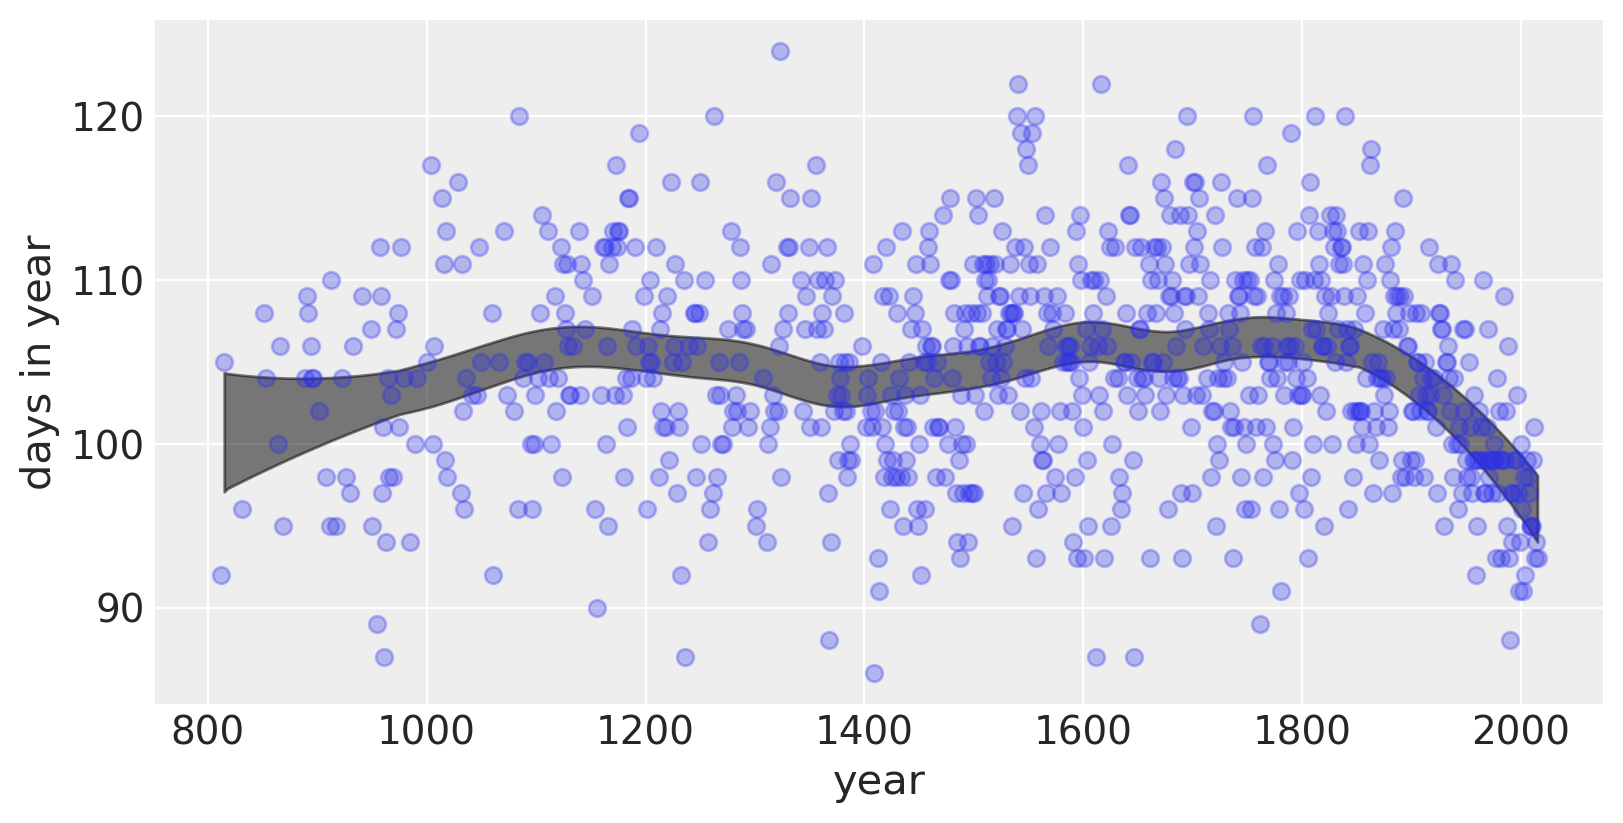

In [41]:
ax = az.plot_hdi(cherry_data.year, m4m8_a_trace.posterior["mu"], color="k")
ax.plot(cherry_data.year, cherry_data.doy, "o", alpha=0.3)
fig = plt.gcf()
fig.set_size_inches(8, 4)
ax.set_xlabel("year")
ax.set_ylabel("days in year")

In [42]:
with pm.Model() as m4m8_c:
    a = pm.Normal('a', 100,10)
    w = pm.Normal('w', mu=0, sigma=1, shape=B.shape[1])
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic("mu", a + pm.math.dot(B.base, w.T))
    D = pm.Normal('D', mu, sigma, observed=cherry_data['doy'])
    m4m8_c_trace = pm.sample(1000)                       

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


Text(0, 0.5, 'days in year')

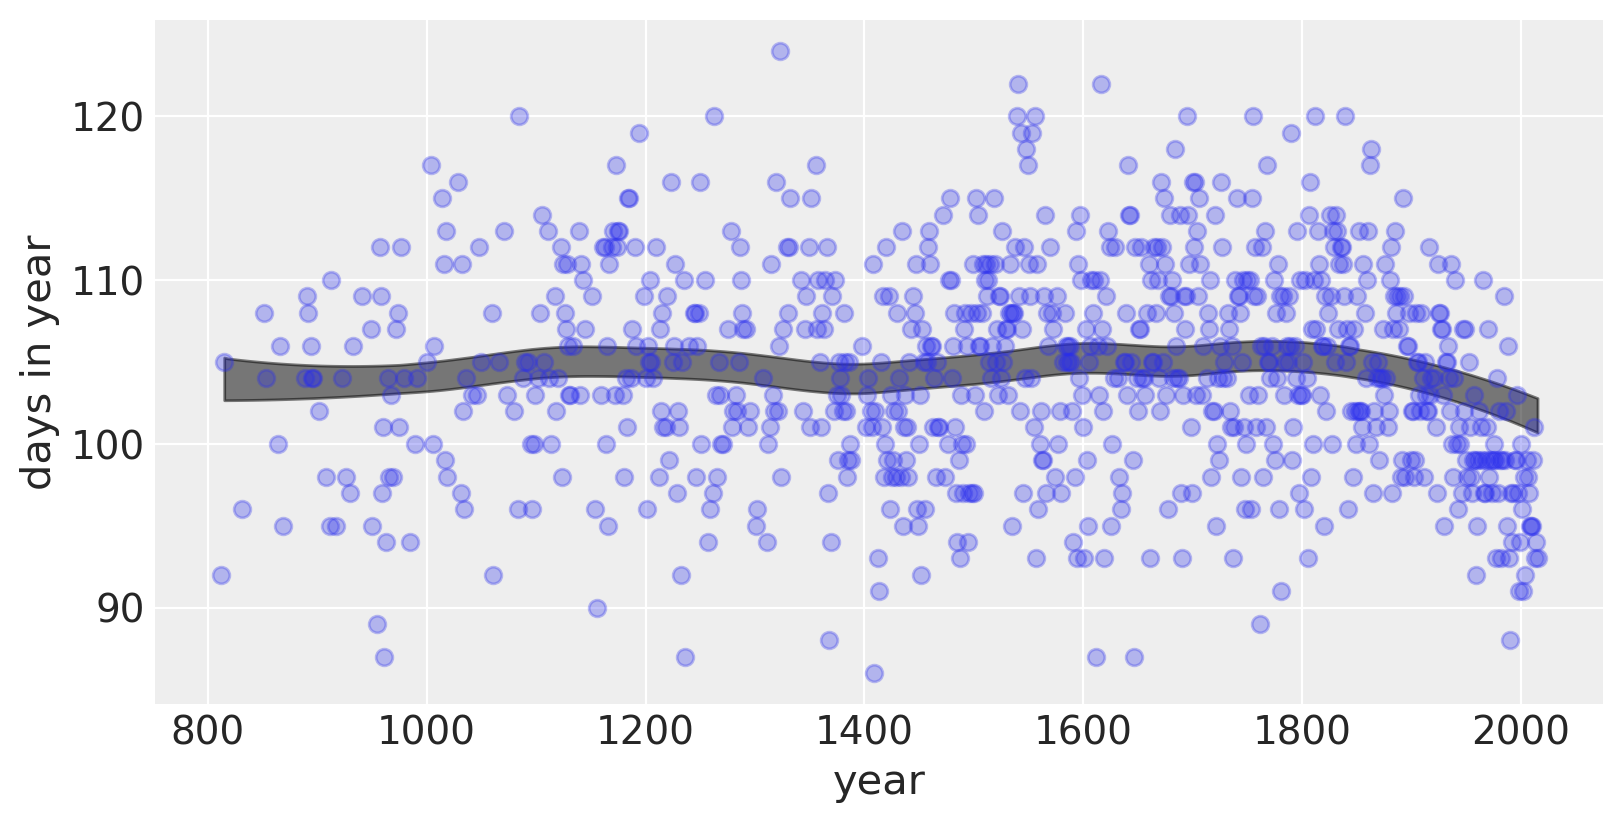

In [43]:
ax = az.plot_hdi(cherry_data.year, m4m8_c_trace.posterior["mu"], color="k")
ax.plot(cherry_data.year, cherry_data.doy, "o", alpha=0.3)
fig = plt.gcf()
fig.set_size_inches(8, 4)
ax.set_xlabel("year")
ax.set_ylabel("days in year")

# 4H1

In [44]:
data_raw = pd.read_csv("./data/Howell1.csv", sep=';')
data = data_raw[data_raw['age'] >= 18]
weights_data = [46.95,43.72,64.78,32.59,54.63]

In [45]:
#4H1
with pm.Model() as m4h1:
    weights = pm.MutableData('weights', data['weight'].values)
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.Normal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0,50)
    mu = a + b*(weights)
    height = pm.Normal("height", mu=mu, sigma=sigma, shape=mu.shape, observed=data['height'].values)  
    m4h1_trace = pm.sample(1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


In [46]:
az.summary(m4h1_trace)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a      114.513  1.957   111.480    117.687      0.055    0.039    1285.0   
b        0.891  0.043     0.825      0.963      0.001    0.001    1279.0   
sigma    5.108  0.200     4.808      5.435      0.005    0.003    1782.0   

       ess_tail  r_hat  
a        1434.0    1.0  
b        1510.0    1.0  
sigma    1554.0    1.0

In [47]:
with m4h1:
    pm.set_data({'weights':np.array(weights_data)})
    predictions = pm.sample_posterior_predictive(m4h1_trace)

Sampling: [height]


In [48]:
az_summary = pd.DataFrame(az.summary(predictions['posterior_predictive'],hdi_prob=0.89))

In [49]:
pd.DataFrame({'Weight':weights_data,
             'Expected Height':az_summary.iloc[:,0].values,
            'Lower_Interval':az_summary.iloc[:,2].values,
              'Higher_Interval':az_summary.iloc[:,3].values
             })

Weight  Expected Height  Lower_Interval  Higher_Interval
0   46.95          156.258         147.845          164.171
1   43.72          153.466         145.138          161.691
2   64.78          172.282         163.842          180.346
3   32.59          143.663         135.108          151.758
4   54.63          163.231         155.050          171.217

# 4H2

In [50]:
data_raw = pd.read_csv("./data/Howell1.csv", sep=';')
data_raw.head()
data_less18 = data_raw[data_raw['age'] < 18]
data_less18.shape

(192, 4)

In [51]:
with pm.Model() as m_4h2:
    weights = pm.MutableData('weights', data_less18['weight'].values)
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.Normal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0,50)
    mu = a + b*(weights)
    height = pm.Normal("height", mu=mu, sigma=sigma, shape=mu.shape, observed=data_less18['height'].values)  
    m4h2_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [52]:
az.summary(m4h2_trace)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a      59.080  1.372    56.916     61.258      0.033    0.023    1769.0   
b       2.680  0.067     2.575      2.784      0.002    0.001    1817.0   
sigma   8.553  0.437     7.826      9.192      0.009    0.006    2471.0   

       ess_tail  r_hat  
a        1907.0    1.0  
b        1958.0    1.0  
sigma    2353.0    1.0

## Answer to 4h2a - 26.7cm

In [53]:
#4h2b
weight_seq = np.arange(0,50,1)
a_values = m4h2_trace['posterior']['a'][0]
b_values = m4h2_trace['posterior']['b'][0]
predictions = np.zeros((len(weight_seq), len(a_values)))

In [54]:
for i, value in enumerate(weight_seq):
    predictions[i] = a_values + (b_values * (value))

In [55]:
predictions_mean = predictions.mean(1)
predictions_hdi = az.hdi(predictions_mean.T)

In [56]:
with m_4h2:
    height_pred = pm.sample_posterior_predictive(m4h2_trace)

Sampling: [height]


D:\Python\venv\pymc_env\lib\site-packages\arviz\plots\hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


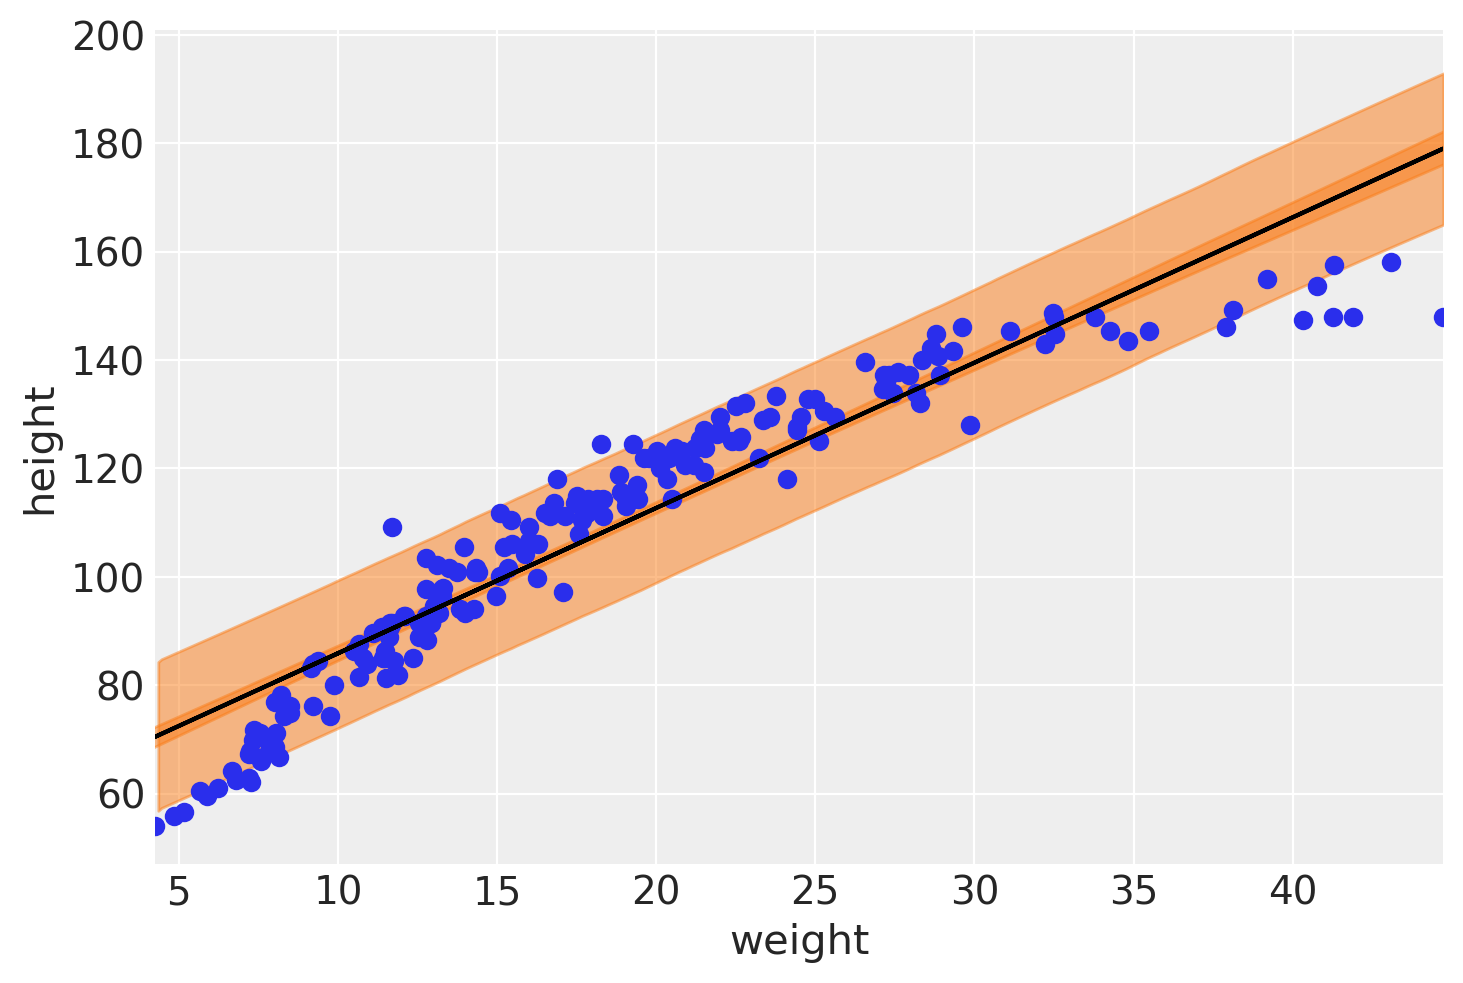

In [57]:
ax = az.plot_hdi(weight_seq, predictions.T, hdi_prob=0.89)
az.plot_hdi(data_less18['weight'], height_pred.posterior_predictive['height'], ax=ax, hdi_prob=0.89)
plt.scatter(data_less18['weight'],data_less18['height'])
plt.plot(data_less18['weight'],
         m4h2_trace.posterior['a'].mean().item(0) 
         + m4h2_trace.posterior['b'].mean().item(0) * (data_less18['weight']), color='black')
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(data_less18['weight'].min(), data_less18['weight'].max());

## Answer to 4h2c - The model is overestimating ages below 10 and over 30, but underesimating between that. The data is also curved, the fit is a straight line.

# 4H3

In [58]:
weights_log = np.log(data_raw['weight'])
weights_log_adj = weights_log - np.mean(weights_log)
with pm.Model() as m_4h3:
    weights = pm.MutableData('weights', weights_log_adj)
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.LogNormal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0,50)
    mu =  a + (b*weights)
    height = pm.Normal("height", mu=mu, sigma=sigma, shape=mu.shape, observed=data_raw['height'].values)  
    m4h3_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [59]:
az.summary(m4h3_trace)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a      138.271  0.223   137.922    138.632      0.003    0.002    6139.0   
b       47.070  0.389    46.426     47.666      0.005    0.004    5615.0   
sigma    5.157  0.153     4.918      5.394      0.002    0.001    5933.0   

       ess_tail  r_hat  
a        3083.0    1.0  
b        2697.0    1.0  
sigma    3251.0    1.0

In [60]:
np.ceil(np.max(data['weight']))

63.0

In [61]:
weight_seq = np.log(np.arange(5,63,1))
weight_seq_adj =  weight_seq - np.mean(weight_seq)
a_values = m4h3_trace['posterior']['a'][0]
b_values = m4h3_trace['posterior']['b'][0]
predictions = np.zeros((len(weight_seq_adj), len(a_values)))

In [62]:
for i, value in enumerate(weight_seq_adj):
    predictions[i] = a_values + (b_values * value)

In [63]:
predictions_mean = predictions.mean(1)
predictions_hdi = az.hdi(predictions_mean.T)

In [64]:
with m_4h3:
    height_pred = pm.sample_posterior_predictive(m4h3_trace)

Sampling: [height]


D:\Python\venv\pymc_env\lib\site-packages\arviz\plots\hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


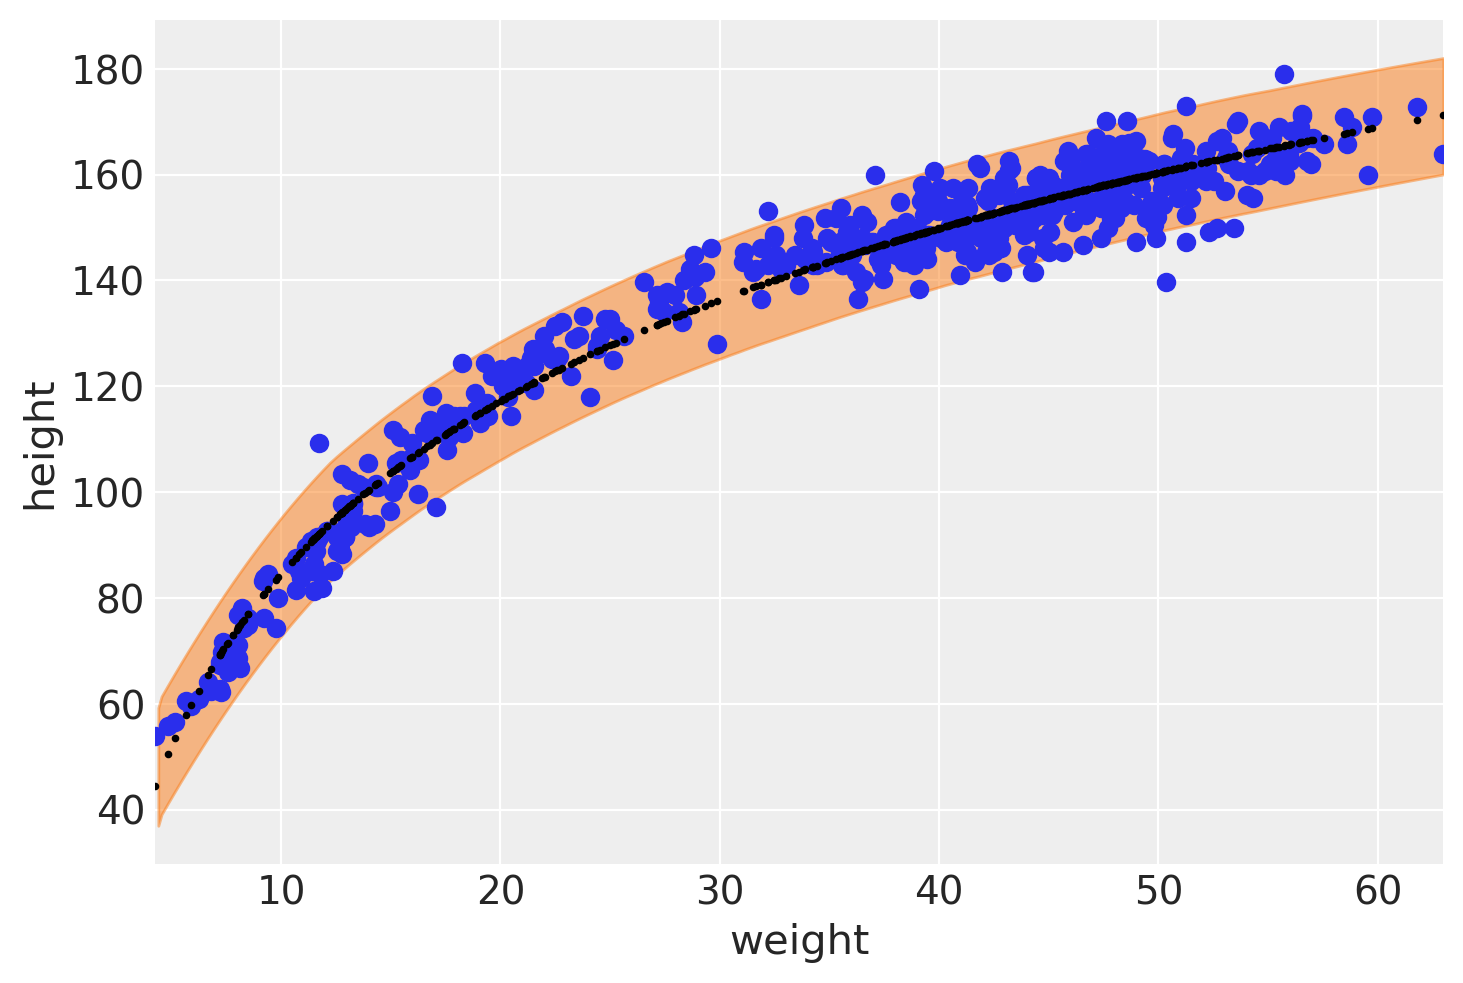

In [65]:
ax = az.plot_hdi(weight_seq, predictions.T, hdi_prob=0.97)
az.plot_hdi(data_raw['weight'], height_pred.posterior_predictive['height'], ax=ax, hdi_prob=0.97)
plt.scatter(data_raw['weight'], data_raw['height'])
plt.scatter(data_raw['weight'],
         m4h3_trace.posterior['a'].mean().item(0) 
         + m4h3_trace.posterior['b'].mean().item(0) * (weights_log_adj), color='black', s=3)
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(data_raw['weight'].min(), data_raw['weight'].max());

# 4H4

In [66]:
#weights_std = (data_raw['weight'] - np.mean(data_raw['weight'])) / np.std(data_raw['weight'])
#weights_std_sqrd = weights_std ** 2
with pm.Model() as m4h4:
    a = pm.Normal('a', 178,20)
    b1 = pm.Lognormal('b1', 0,1)
    b2 = pm.Normal('b2', 0,1)
    sigma = pm.Uniform("sigma", 0,50)
    mu = a + b1*data_raw['weight'].values + b2*(data_raw['weight'].values ** 2 )
    height = pm.Normal("height", mu, sigma, observed=data_raw['height'].values)
    pp = pm.sample_prior_predictive(1000)
    m4h4_trace = pm.sample(1000, tune=1000)

Sampling: [a, b1, b2, height, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b1, b2, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


In [67]:
az.summary(m4h4_trace)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a      46.148  1.200    44.285     48.096      0.036    0.025    1140.0   
b2     -0.038  0.001    -0.040     -0.036      0.000    0.000    1076.0   
b1      4.184  0.084     4.041      4.308      0.003    0.002    1035.0   
sigma   5.781  0.174     5.498      6.046      0.005    0.003    1438.0   

       ess_tail  r_hat  
a        1429.0    1.0  
b2       1274.0    1.0  
b1       1223.0    1.0  
sigma    1758.0    1.0

In [68]:
pp_weights_seq = np.linspace(0,70)
pp_prior = pp['prior']
predictions = np.zeros((len(pp_weights_seq), 1000))

In [69]:
for i,value in enumerate(pp_weights_seq):
    predictions[i] = pp_prior['a'] + pp_prior['b1'] * value + pp_prior['b2'] * value ** 2

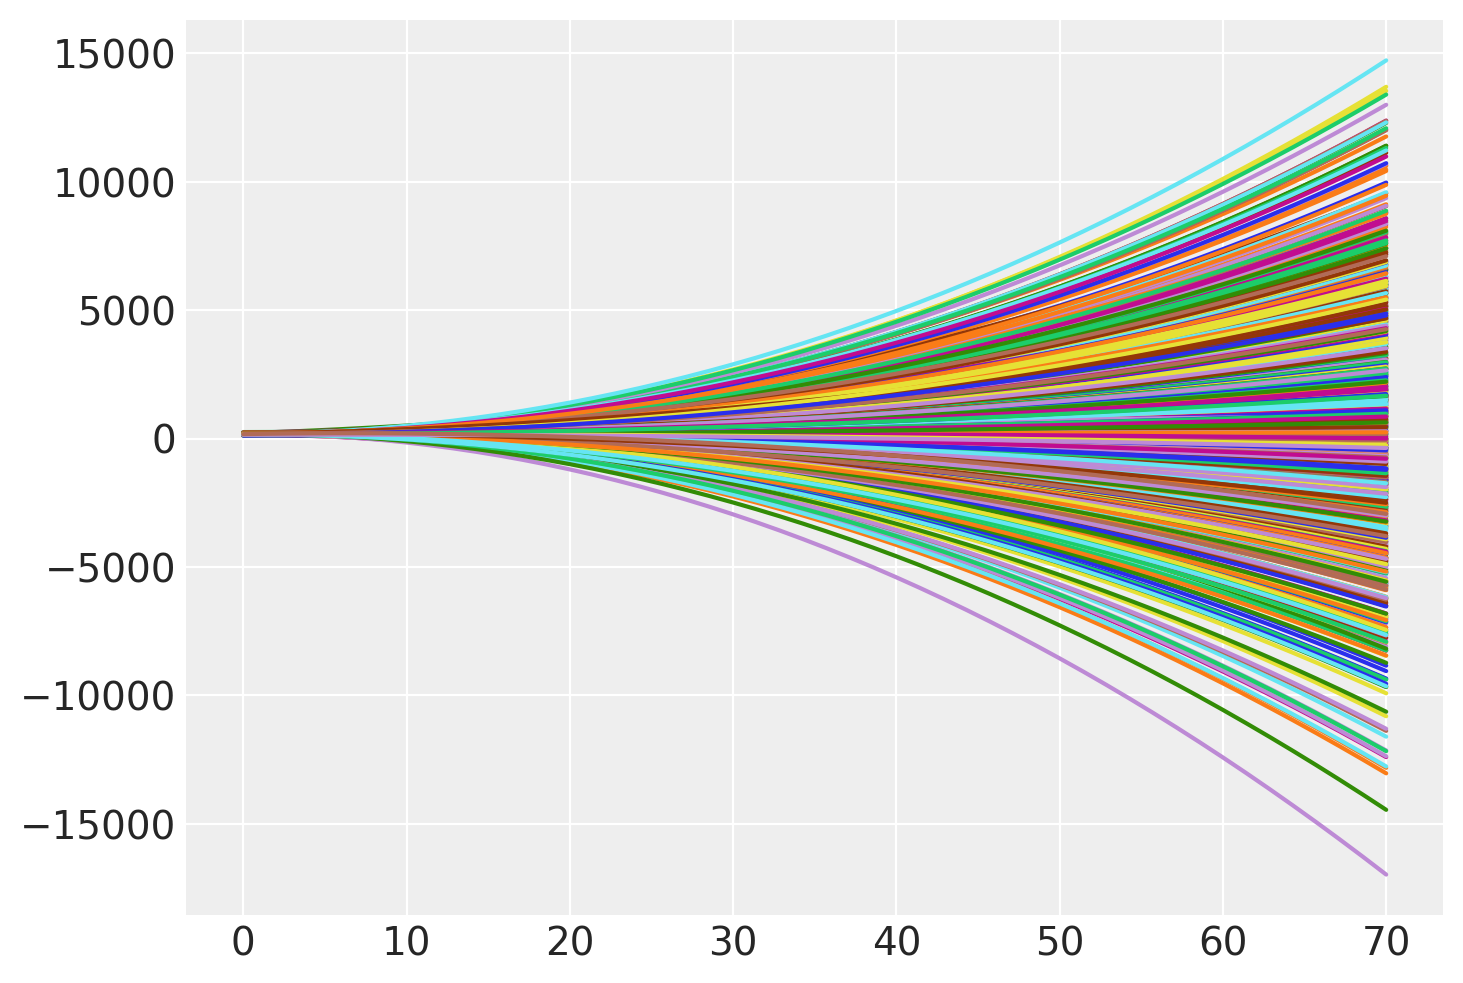

In [70]:
#ax = az.plot_hdi(x, predictions.T, hdi_prob=0.89)
for i in predictions.T:
    plt.plot(pp_weights_seq, i)

In [71]:
data_raw['height'].max(), data_raw['height'].min(), data_raw['height'].median()

(179.07, 53.975, 148.59)

In [72]:
N = 1000
a_priors = np.random.normal(140,25, N) #Move he height closer to the mean value and increase the sd
b1_priors = np.random.lognormal(0,1,N)
b2_priors = np.random.lognormal(0,5,N) #Forces the growth to be positive and rising more slowly

In [73]:
pp_weights_seq = np.linspace(0,70)
predictions = np.zeros((len(pp_weights_seq), N))
for i, value in enumerate(pp_weights_seq):
    predictions[i] = a_priors + (b1_priors * value) + (b2_priors * (value ** 2))

(0.0, 300.0)

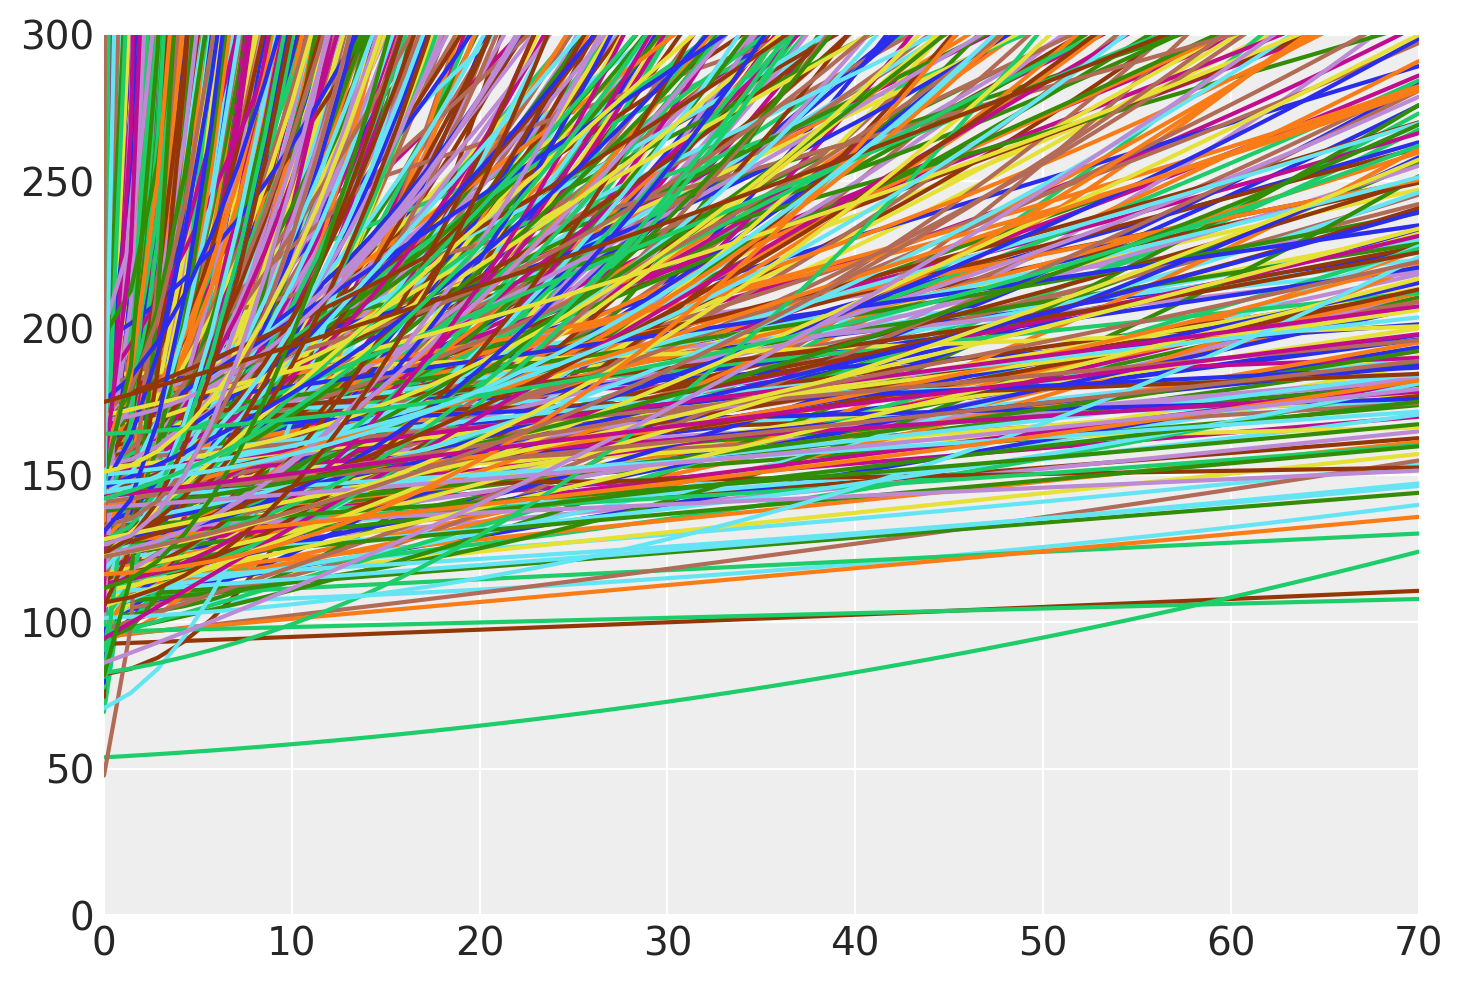

In [74]:
for i in predictions.T:
    plt.plot(pp_weights_seq, i)
plt.xlim(0, 70);
plt.ylim(0,300)

# 4H5

In [75]:
cherry_data_raw = pd.read_csv("./data/cherry_blossoms.csv")

In [76]:
cherry_data_raw.describe()

year         doy         temp   temp_upper   temp_lower
count  1215.000000  827.000000  1124.000000  1124.000000  1124.000000
mean   1408.000000  104.540508     6.141886     7.185151     5.098941
std     350.884596    6.407036     0.663648     0.992921     0.850350
min     801.000000   86.000000     4.670000     5.450000     0.750000
25%    1104.500000  100.000000     5.700000     6.480000     4.610000
50%    1408.000000  105.000000     6.100000     7.040000     5.145000
75%    1711.500000  109.000000     6.530000     7.720000     5.542500
max    2015.000000  124.000000     8.300000    12.100000     7.740000

In [77]:
cherry_data = cherry_data_raw.dropna()

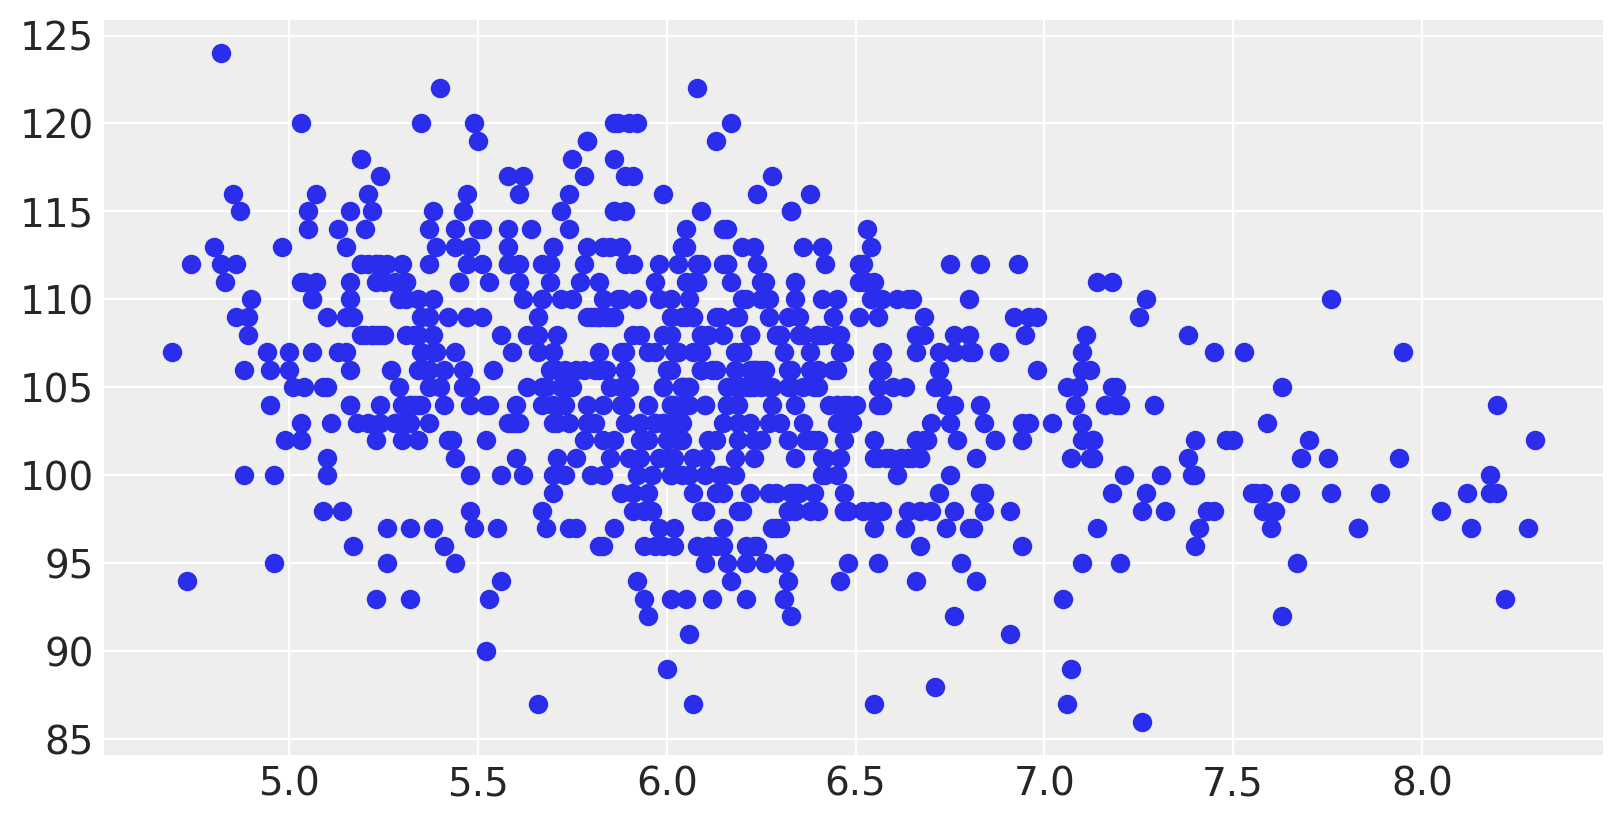

In [78]:
plt.figure(figsize=(8,4))
plt.scatter(cherry_data['temp'],cherry_data['doy'])

In [79]:
with pm.Model() as m4h5_linear:
    a = pm.Normal("a",100, 10)
    b = pm.Normal("b",0, 10)
    sigma = pm.Uniform("sigma", 0,50)
    mu = a + b * cherry_data['temp'].values
    doy = pm.Normal("doy", mu, sigma, observed=cherry_data['doy'].values)
    m4h5_linear_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


In [80]:
az.summary(m4h5_linear_trace)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a      122.352  1.852   119.536    125.388      0.048    0.034    1465.0   
b       -2.859  0.302    -3.361     -2.418      0.008    0.006    1475.0   
sigma    5.928  0.148     5.711      6.178      0.003    0.002    1907.0   

       ess_tail  r_hat  
a        1450.0    1.0  
b        1460.0    1.0  
sigma    1805.0    1.0

In [81]:
with m4h5_linear:
    doy_pred_linear = pm.sample_posterior_predictive(m4h5_linear_trace)

Sampling: [doy]


Text(0, 0.5, 'Day Of Year')

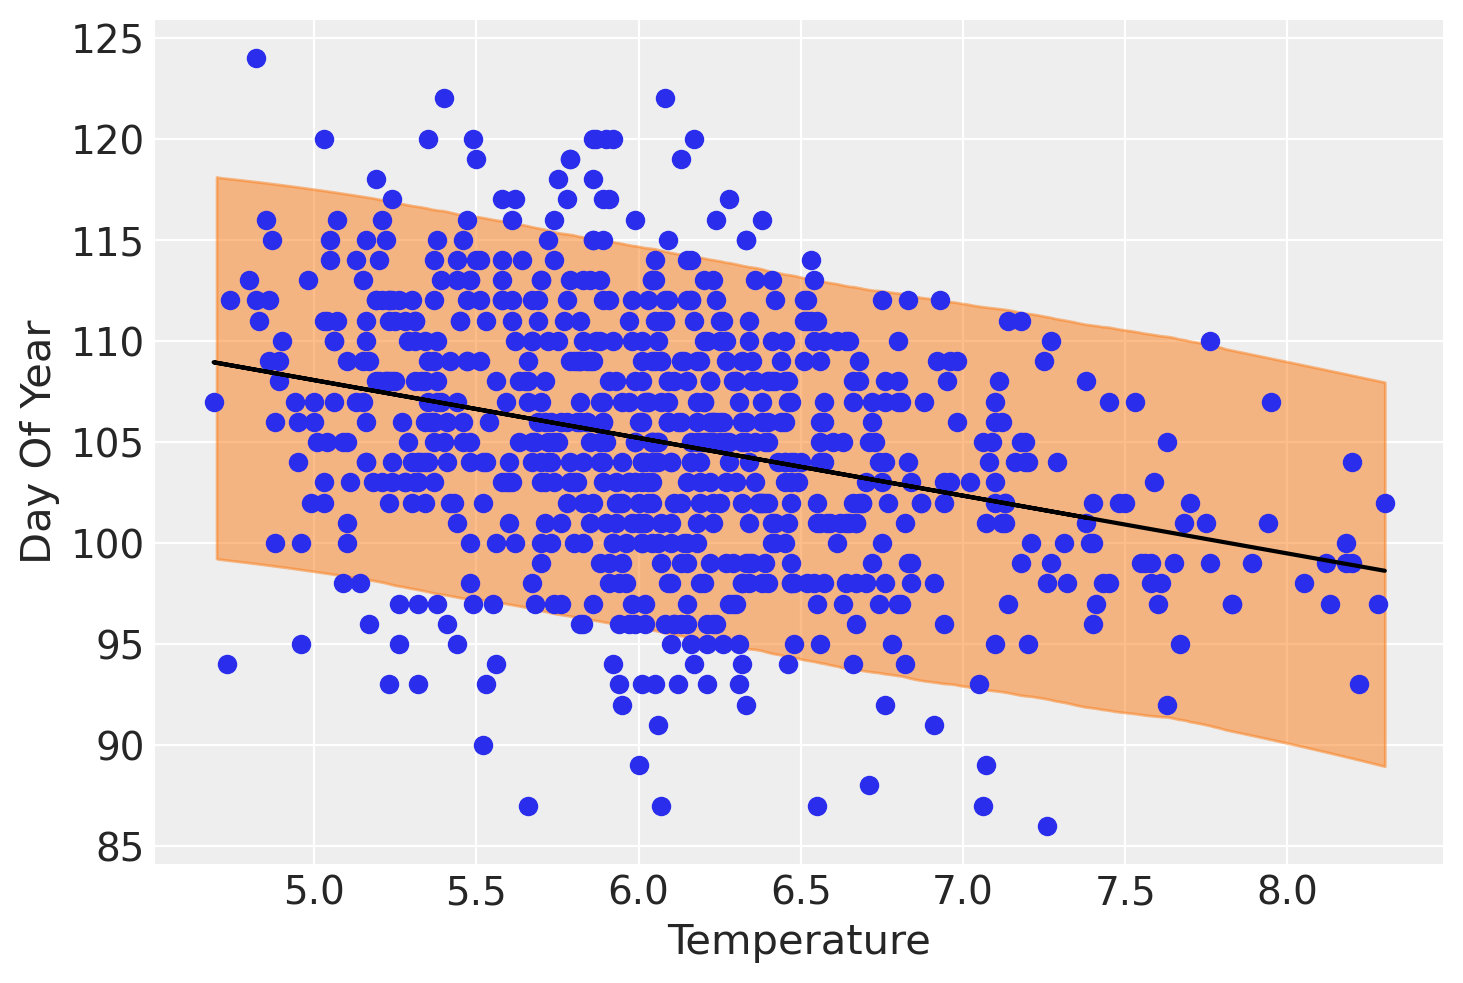

In [82]:
az.plot_hdi(cherry_data['temp'], doy_pred_linear.posterior_predictive['doy'], hdi_prob=0.89)
plt.scatter(cherry_data['temp'], cherry_data['doy'])
plt.plot(cherry_data['temp'],
         m4h5_linear_trace['posterior']['a'].mean().item(0) 
         + m4h5_linear_trace['posterior']['b'].mean().item(0) * (cherry_data['temp']), color='black')
plt.xlabel("Temperature")
plt.ylabel("Day Of Year")
# plt.xlim(data_raw['weight'].min(), data_raw['weight'].max());

In [83]:
with pm.Model() as m4h5_poly:
    a = pm.Normal("a",100, 10)
    b1 = pm.Normal("b1",0, 10)
    b2 = pm.Normal("b2",0, 10)
    sigma = pm.Uniform("sigma", 0,50)
    mu = a + b1 * cherry_data['temp'].values + b2 * (cherry_data['temp'].values**2)
    doy = pm.Normal("doy", mu, sigma, observed=cherry_data['doy'].values)
    m4h5_poly_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b1, b2, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.


In [84]:
az.summary(m4h5_poly_trace)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a      109.673  7.919    95.784    121.345      0.261    0.184     930.0   
b1       1.307  2.536    -2.641      5.489      0.084    0.068     915.0   
b2      -0.338  0.203    -0.678     -0.030      0.007    0.005     922.0   
sigma    5.935  0.150     5.687      6.164      0.004    0.003    1520.0   

       ess_tail  r_hat  
a         794.0    1.0  
b1        783.0    1.0  
b2        821.0    1.0  
sigma    1530.0    1.0

In [85]:
with m4h5_poly:
    doy_pred_poly = pm.sample_posterior_predictive(m4h5_poly_trace)

Sampling: [doy]


Text(0, 0.5, 'Day Of Year')

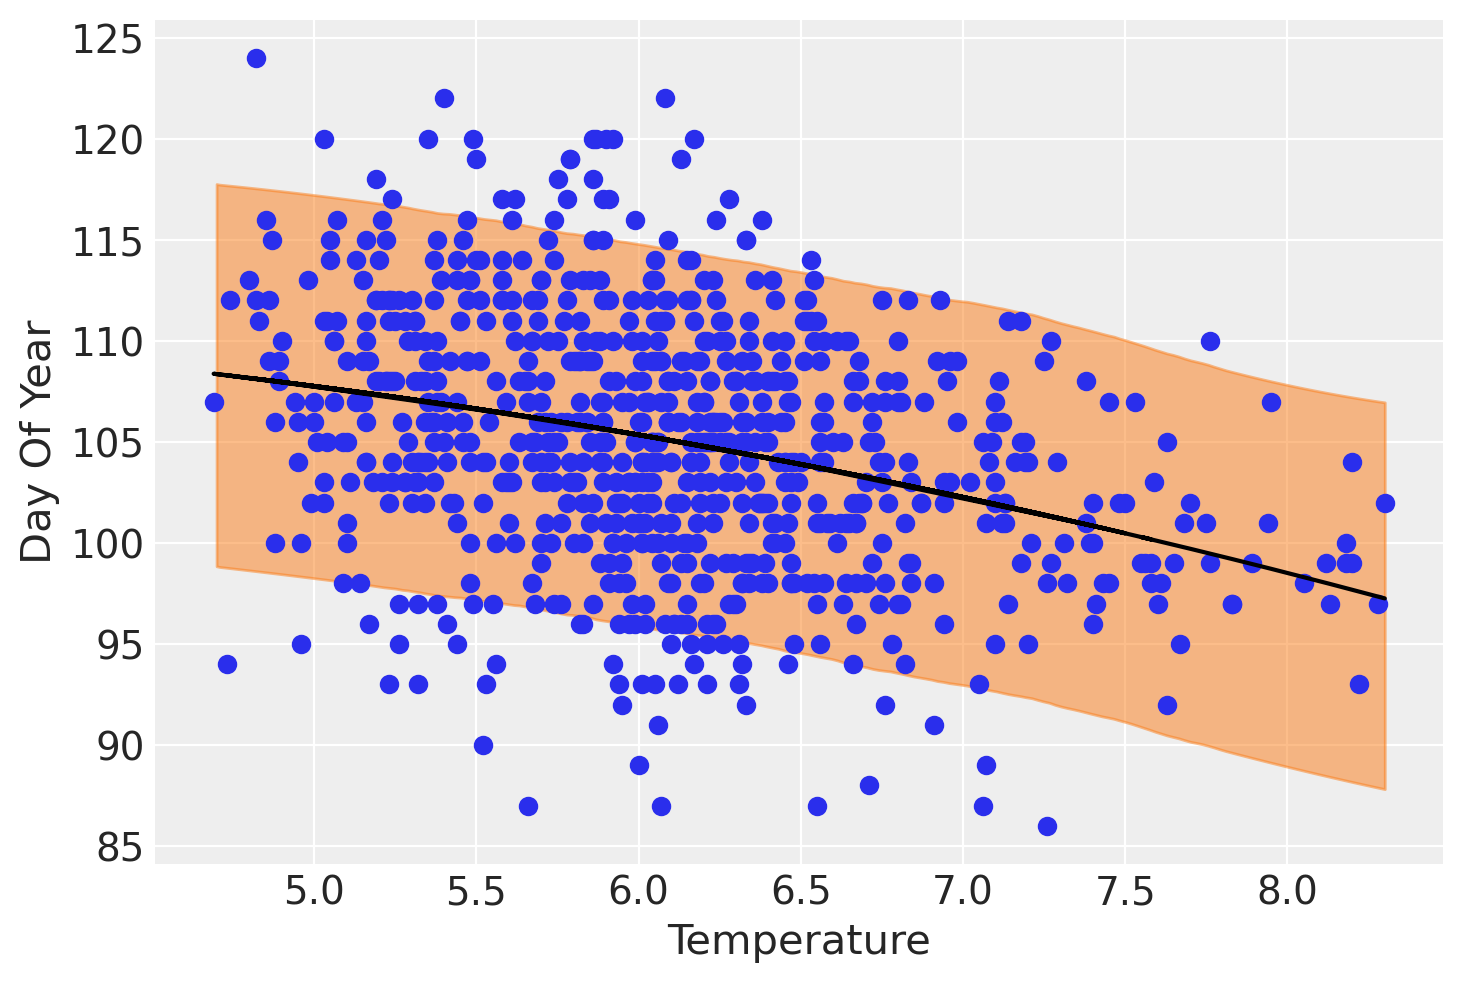

In [86]:
az.plot_hdi(cherry_data['temp'], doy_pred_poly.posterior_predictive['doy'], hdi_prob=0.89)
plt.scatter(cherry_data['temp'], cherry_data['doy'])
plt.plot(cherry_data['temp'],
         m4h5_poly_trace['posterior']['a'].mean().item(0) 
         + m4h5_poly_trace['posterior']['b1'].mean().item(0) * (cherry_data['temp'])
         + m4h5_poly_trace['posterior']['b2'].mean().item(0) * (cherry_data['temp']**2), color='black')
plt.xlabel("Temperature")
plt.ylabel("Day Of Year")
# plt.xlim(data_raw['weight'].min(), data_raw['weight'].max());

In [87]:
poly_error = np.mean(
    (cherry_data['temp']  - (m4h5_poly_trace['posterior']['a'].mean().item(0) 
+ m4h5_poly_trace['posterior']['b1'].mean().item(0) * (cherry_data['temp'])
+ m4h5_poly_trace['posterior']['b2'].mean().item(0) * (cherry_data['temp'])**2)
    )**2
)

In [88]:
linear_error = np.mean(
    (cherry_data['temp']  - (m4h5_linear_trace['posterior']['a'].mean().item(0) 
+ m4h5_linear_trace['posterior']['b'].mean().item(0) * cherry_data['temp'])
                                               )**2)

In [89]:
with pm.Model() as m4h5_quad:
    a = pm.Normal("a",100, 10)
    b1 = pm.Normal("b1",0, 10)
    b2 = pm.Normal("b2",0, 10)
    b3 = pm.Normal("b3",0, 10)
    sigma = pm.Uniform("sigma", 0,50)
    mu = a + b1 * cherry_data['temp'].values + b2 * (cherry_data['temp'].values**2) + b3 * (cherry_data['temp'].values**3)
    doy = pm.Normal("doy", mu, sigma, observed=cherry_data['doy'].values)
    m4h5_quad_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b1, b2, b3, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 174 seconds.


In [90]:
az.summary(m4h5_quad_trace)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a      103.477  9.067    89.805    118.878      0.284    0.201    1014.0   
b1       6.323  4.580    -0.943     13.537      0.163    0.115     791.0   
b2      -1.452  0.882    -2.830     -0.040      0.031    0.022     806.0   
b3       0.075  0.058    -0.018      0.166      0.002    0.001     892.0   
sigma    5.930  0.144     5.694      6.147      0.003    0.002    2030.0   

       ess_tail  r_hat  
a        1628.0   1.00  
b1       1247.0   1.01  
b2       1057.0   1.01  
b3       1116.0   1.01  
sigma    2027.0   1.00

In [91]:
with m4h5_quad:
    doy_pred_quad = pm.sample_posterior_predictive(m4h5_quad_trace)

Sampling: [doy]


Text(0, 0.5, 'Day Of Year')

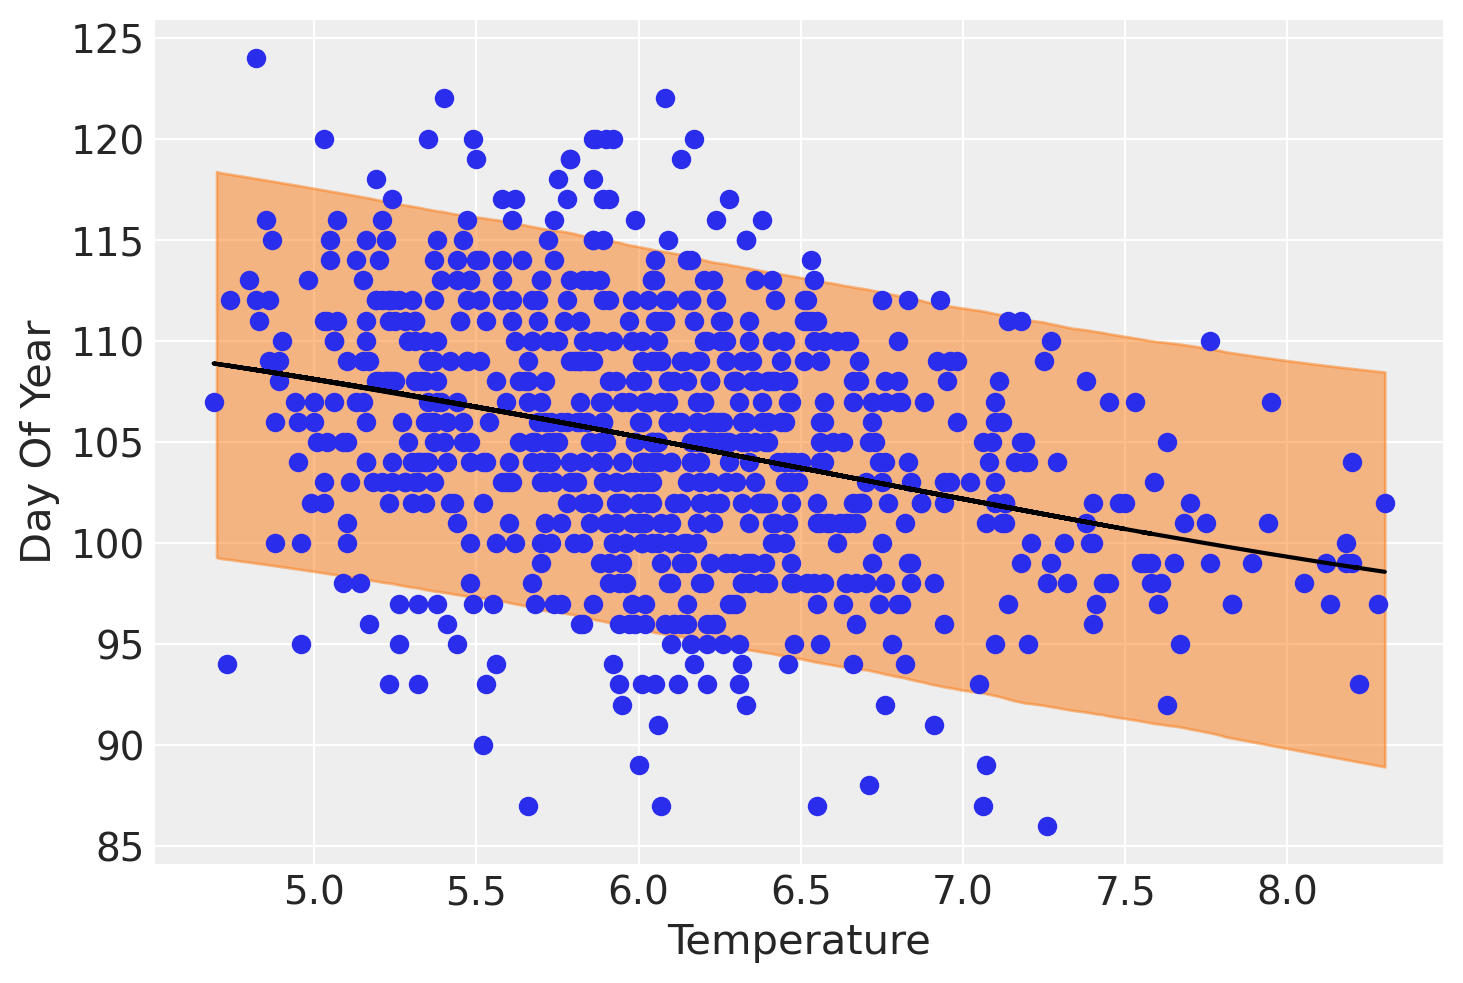

In [92]:
az.plot_hdi(cherry_data['temp'], doy_pred_quad.posterior_predictive['doy'], hdi_prob=0.89)
plt.scatter(cherry_data['temp'], cherry_data['doy'])
plt.plot(cherry_data['temp'],
         m4h5_quad_trace['posterior']['a'].mean().item(0) 
         + m4h5_quad_trace['posterior']['b1'].mean().item(0) * (cherry_data['temp'])
         + m4h5_quad_trace['posterior']['b2'].mean().item(0) * (cherry_data['temp']**2)
         + m4h5_quad_trace['posterior']['b3'].mean().item(0) * (cherry_data['temp']**3), color='black')
plt.xlabel("Temperature")
plt.ylabel("Day Of Year")
# plt.xlim(data_raw['weight'].min(), data_raw['weight'].max());

In [94]:
quad_error = np.mean(
    (cherry_data['temp']  - (m4h5_quad_trace['posterior']['a'].mean().item(0) 
+ m4h5_quad_trace['posterior']['b1'].mean().item(0) * (cherry_data['temp'])
+ m4h5_quad_trace['posterior']['b2'].mean().item(0) * (cherry_data['temp'])**2
+ m4h5_quad_trace['posterior']['b2'].mean().item(0) * (cherry_data['temp'])**3)
    )**2
)

In [95]:
print(f'Linear Error:{linear_error}, Poly Error:{poly_error}, Quad Error:{quad_error}')

Linear Error:9770.434066660902, Poly Error:9772.679685491441, Quad Error:85008.84747849709


## Generally speaking, it does seems like there is a trend of higher temperatures resulting in earlier blossoms.  That being said, the interval is quite large, and there are lots of points. out of the interval.  So I'm not really confident this model is useful and tells us more than you can just see with your eyeballs.

# 4H8

In [96]:
num_knots = 10
knot_list = np.quantile(cherry_data['year'],np.linspace(0,1,num_knots))

In [97]:
#from patsy import dmatrix

B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=False)-1",
    {"year": cherry_data['year'].values, "knots": knot_list[1:-1]},
)

In [98]:
B.shape

(787, 11)

In [99]:
n = 10
a = np.random.normal(100,10,n+1)
w = np.random.normal(0,2, (n, B.shape[1]))

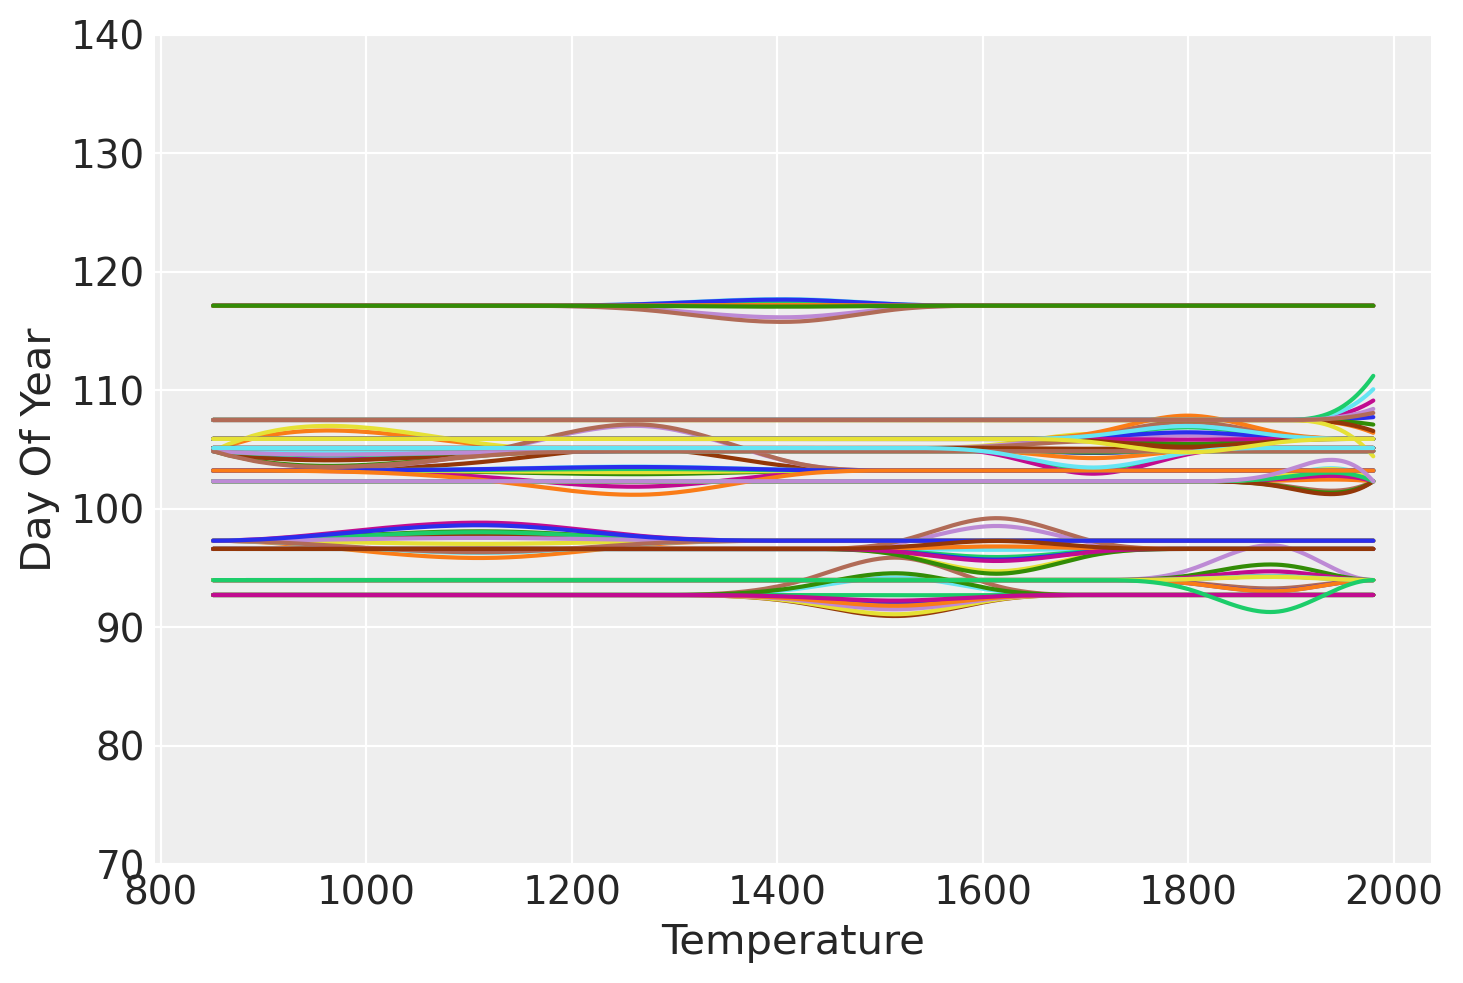

In [100]:
plt.xlabel("Temperature")
plt.ylabel("Day Of Year")
plt.ylim(70,140)
for weights in w:
    updated_splines = B.base * weights
    for i, spline in enumerate(updated_splines.T):
        plt.plot(cherry_data['year'], a[i] + spline)

In [101]:
num_knots = 10
knot_list = np.quantile(cherry_data['year'],np.linspace(0,1,num_knots))

In [102]:
B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True)-1",
    {"year": cherry_data['year'].values, "knots": knot_list[1:-1]},
)

In [103]:
with pm.Model() as mh48:
    #a = pm.Normal('a', 100,10)
    w = pm.Normal('w', 100, 10, shape=B.shape[1])
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic("mu", pm.math.dot(B.base, w.T))
    D = pm.Normal('D', mu, sigma, observed=cherry_data['doy'])
    mh48_trace = pm.sample(1000)                       

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


In [104]:
az.summary(mh48_trace)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
w[0]     104.369  2.885    99.564    108.688      0.044    0.031    4222.0   
w[1]     100.193  2.689    95.903    104.467      0.048    0.034    3092.0   
w[2]     106.852  2.220   103.143    110.145      0.042    0.030    2767.0   
w[3]     106.112  1.542   103.490    108.399      0.029    0.021    2800.0   
w[4]     100.588  1.417    98.283    102.821      0.026    0.019    2899.0   
...          ...    ...       ...        ...        ...      ...       ...   
mu[782]   99.279  1.580    96.663    101.696      0.025    0.018    4007.0   
mu[783]   99.227  1.666    96.766    102.103      0.027    0.019    3927.0   
mu[784]   99.177  1.757    96.400    102.037      0.028    0.020    3848.0   
mu[785]   99.128  1.853    96.181    102.139      0.030    0.021    3778.0   
mu[786]   99.081  1.953    95.985    102.260      0.032    0.023    3712.0   

         ess_tail  r_hat  
w[0]       3470.0    1.0  
w[1]       3135.0    1.0  
w[2]       2713.0    1.0  
w[3]       2998.0    1.0  
w[4]       2710.0    1.0  
...           ...    ...  
mu[782]    3061.0    1.0  
mu[783]    2965.0    1.0  
mu[784]    2980.0    1.0  
mu[785]    2899.0    1.0  
mu[786]    3012.0    1.0  

[800 rows x 9 columns]

Text(0, 0.5, 'days in year')

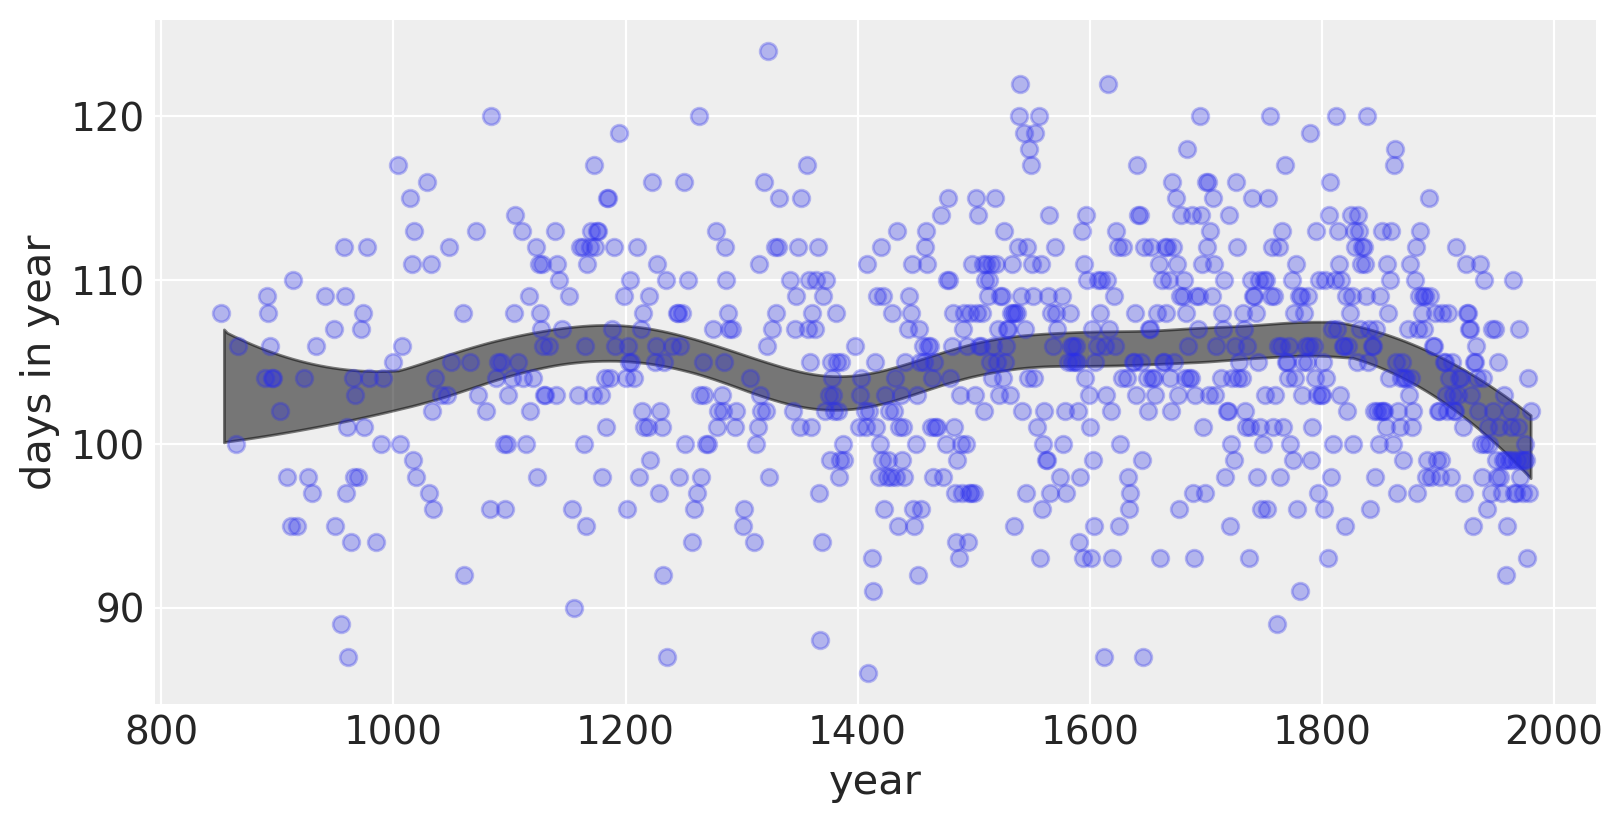

In [105]:
ax = az.plot_hdi(cherry_data.year, mh48_trace.posterior["mu"], color="k")
ax.plot(cherry_data.year, cherry_data.doy, "o", alpha=0.3)
fig = plt.gcf()
fig.set_size_inches(8, 4)
ax.set_xlabel("year")
ax.set_ylabel("days in year")

## Since we remove the intercept, we need to update the prior so the mean is close to where the intercept was